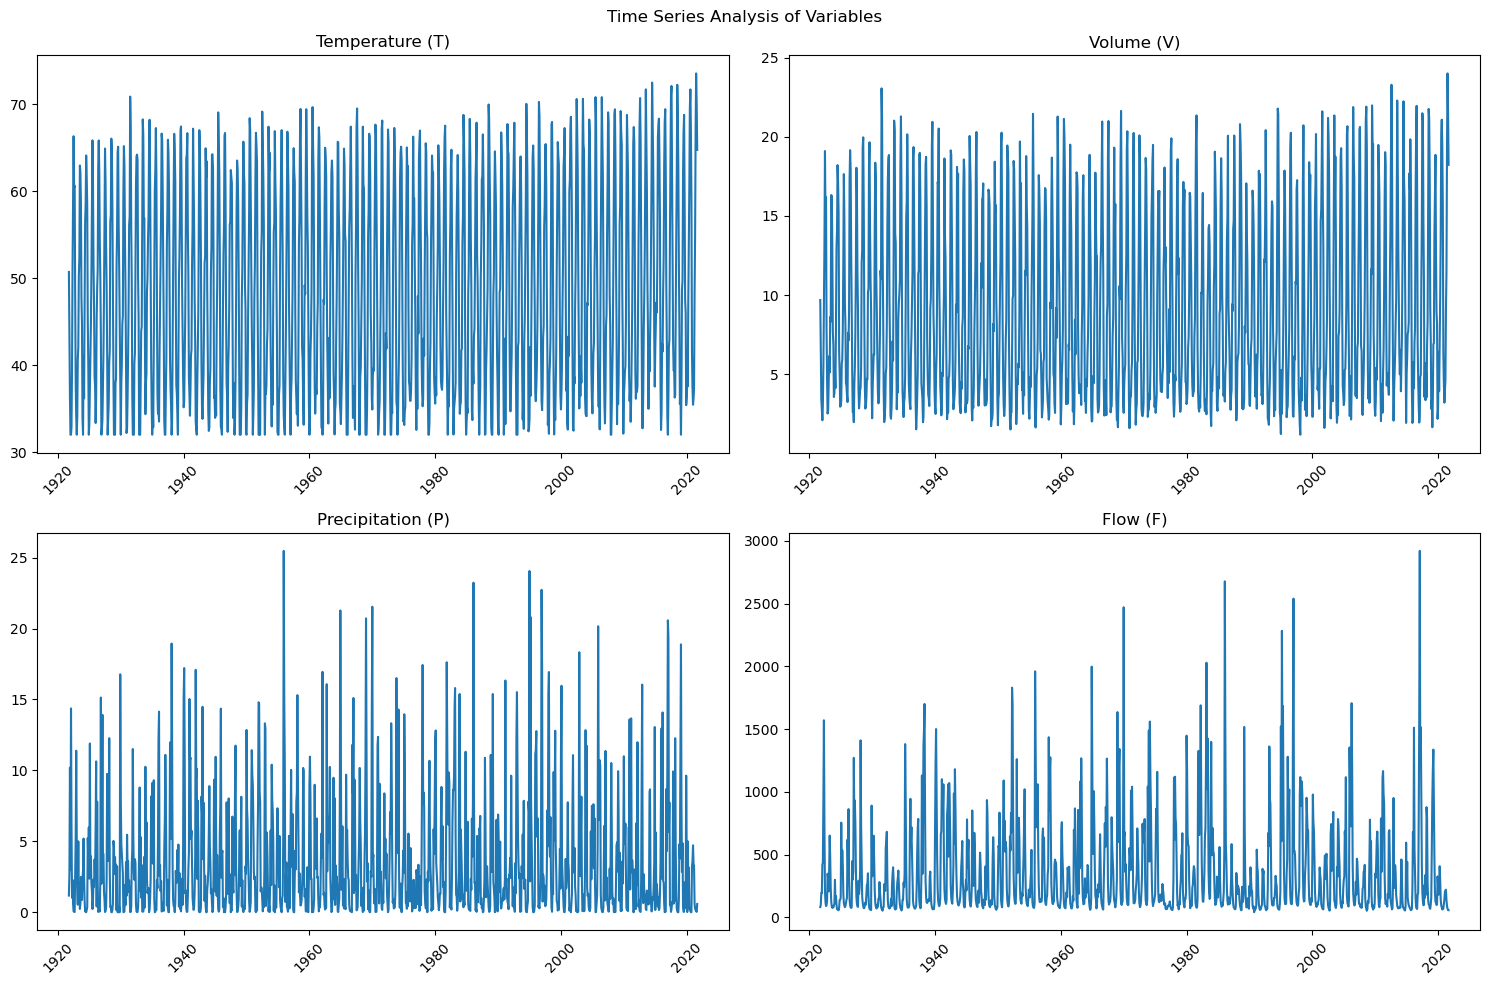

Date          T          V          P        F
0    1921-10-01  50.711506   9.680717   1.173617   81.200
1    1921-11-01  42.727805   6.427311   2.666764  100.000
2    1921-12-01  36.407265   3.427978  10.194451  194.000
3    1922-01-01  32.000000   2.775463   2.969249  192.000
4    1922-02-01  32.000000   2.077533  14.370800  422.000
...         ...        ...        ...        ...      ...
1195 2021-05-01  54.776440  11.438191   0.265424  136.858
1196 2021-06-01  66.966054  19.161114   0.136572   88.619
1197 2021-07-01  73.537018  24.017705   0.086182   70.112
1198 2021-08-01  70.023603  21.625689   0.024613   56.391
1199 2021-09-01  64.739571  18.231172   0.582271   56.281

[1200 rows x 5 columns]

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('Data/Clean/Orov_clean.csv')
columns_to_analyze = ['Date','T', 'V', 'P', 'F']
df = df[columns_to_analyze]

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Time Series Analysis of Variables')

# Plot each variable
axes[0, 0].plot(df['Date'], df['T'])
axes[0, 0].set_title('Temperature (T)')
axes[0, 1].plot(df['Date'], df['V'])
axes[0, 1].set_title('Volume (V)')
axes[1, 0].plot(df['Date'], df['P'])
axes[1, 0].set_title('Precipitation (P)')
axes[1, 1].plot(df['Date'], df['F'])
axes[1, 1].set_title('Flow (F)')

# Format dates and rotate labels
for ax in axes.flatten():
    ax.tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()

df

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.activations import relu
import joblib
import matplotlib.pyplot as plt

# Initial random seed setting
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Hyperparameters
alpha = 0.1  # Smoothness penalty coefficient
beta = 0.1   # Monthly weight coefficient
epochs = 2000  # Training epochs
input_window = 12
output_window = 9
n_features = 4  # PC1 to PC4
batch_size = 32

# Define LSTM architectures
lstm_architectures = [
    [64, 32, 16],  # Original architecture
    [32, 16, 8],   # Simpler 3-layer
    [16, 8, 4],    # Simpler 3-layer
    # [8, 4, 2],     # Simpler 3-layer
    [32, 16],      # 2-layer
    [16, 8],       # 2-layer
    # [8, 4],        # 2-layer
    # [4, 2]         # 2-layer
]

# Custom loss function
def create_custom_flow_loss(alpha, beta):
    def custom_flow_loss(y_true, y_pred):
        month_weights = tf.constant([2, 2, 2, 1.5, 1.5, 1, 1, 1, 1], dtype=tf.float32)
        mse_loss = tf.keras.losses.MSE(y_true, y_pred)
        
        # Smoothness penalty
        smoothness_penalty = tf.reduce_mean(tf.square(y_pred[:, 1:] - y_pred[:, :-1]))
        
        # Monthly weighted loss
        monthly_weight_loss = tf.reduce_mean(month_weights * tf.square(y_true - y_pred))
        
        return mse_loss + alpha * smoothness_penalty + beta * monthly_weight_loss
    return custom_flow_loss

class DataPreprocessor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=4)
        
    def fit_transform(self, df):
        features = df[['T', 'V', 'P', 'F']].values
        features_scaled = self.scaler.fit_transform(features)
        pca_features = self.pca.fit_transform(features_scaled)
        return pca_features
    
    def transform(self, df):
        features = df[['T', 'V', 'P', 'F']].values
        features_scaled = self.scaler.transform(features)
        pca_features = self.pca.transform(features_scaled)
        return pca_features
    
    def save(self, filename):
        preprocessor_dict = {
            'scaler': self.scaler,
            'pca': self.pca
        }
        joblib.dump(preprocessor_dict, filename)
    
    @classmethod
    def load(cls, filename):
        preprocessor = cls()
        loaded_dict = joblib.load(filename)
        preprocessor.scaler = loaded_dict['scaler']
        preprocessor.pca = loaded_dict['pca']
        return preprocessor

def prepare_sequences(features, target):
    X, y = [], []
    for i in range(len(features) - input_window - output_window + 1):
        X.append(features[i:(i + input_window)])
        y.append(target[i + input_window:i + input_window + output_window])
    return np.array(X), np.array(y)

def build_model(architecture):
    # Ensure clean state for model creation
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(architecture[0], activation='relu', return_sequences=True if len(architecture) > 1 else False,
                  input_shape=(input_window, n_features)))
    
    # Middle LSTM layers
    for i in range(1, len(architecture) - 1):
        model.add(LSTM(architecture[i], activation='relu', return_sequences=True))
    
    # Last LSTM layer
    if len(architecture) > 1:
        model.add(LSTM(architecture[-1], activation='relu'))
    
    # Output layer
    model.add(Dense(output_window, activation='relu'))
    
    custom_loss = create_custom_flow_loss(alpha, beta)
    model.compile(optimizer='adam', loss=custom_loss)
    return model

def plot_combined_losses(all_histories, save_path='combined_losses_1921_2000.png'):
    plt.figure(figsize=(15, 8))
    
    # Create a color map for different architectures
    colors = plt.cm.rainbow(np.linspace(0, 1, len(all_histories)))
    
    for (model_name, history), color in zip(all_histories.items(), colors):
        # Extract architecture details directly from the model name
        # Format: lstm_h{num_layers}_{neurons}_a{alpha}_b{beta}_1921_2000
        parts = model_name.split('_')
        
        # Get number of layers (h2 or h3)
        num_layers = parts[1]  # This will be 'h2' or 'h3'
        
        # Get neuron configuration - extract the numbers between the layer indicator and alpha
        neuron_parts = []
        i = 2
        while i < len(parts) and not parts[i].startswith('a'):
            neuron_parts.append(parts[i])
            i += 1
            
        neurons = '_'.join(neuron_parts)
        label = f"{num_layers}_{neurons}"
        
        # Plot with custom formatting
        plt.plot(history['loss'], label=label, color=color, alpha=0.8)
    
    plt.title('Training Loss Comparison Across Different Architectures (1921-2000)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')  # Use log scale for better visualization
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

def get_model_name(architecture, alpha, beta):
    # Create name based on number of hidden layers and neurons
    arch_str = f"h{len(architecture)}_" + "_".join(map(str, architecture))
    return f"lstm_{arch_str}_a{alpha}_b{beta}_1921_2000"

def train_models(df):
    # Initialize and fit preprocessor (only once)
    preprocessor = DataPreprocessor()
    pca_features = preprocessor.fit_transform(df)
    
    # Save preprocessor
    preprocessor.save('preprocessor_1921_2000.joblib')
    
    # Prepare sequences (only once)
    X, y = prepare_sequences(pca_features, df['F'].values)
    
    # Dictionary to store all training histories
    all_histories = {}
    
    # Train models with different architectures
    for architecture in lstm_architectures:
        # Clear everything from previous iteration
        tf.keras.backend.clear_session()
        
        # Reset random seeds for complete reproducibility
        np.random.seed(RANDOM_SEED)
        tf.random.set_seed(RANDOM_SEED)
        
        # Get model name
        model_name = get_model_name(architecture, alpha, beta)
        print(f"\nTraining model: {model_name}")
        print(f"Architecture: {architecture}")
        
        # Build and train model
        model = build_model(architecture)
        print(model.summary())
        
        # Train model
        history = model.fit(X, y,
                          epochs=epochs,
                          batch_size=batch_size,
                          verbose=0)
        
        # Save model
        model.save(f'{model_name}.keras')
        
        # Store training history
        all_histories[model_name] = history.history
        
        # Print current model's final loss
        final_loss = history.history['loss'][-1]
        print(f"\nFinal loss for {model_name}: {final_loss:.4f}")
    
    # Plot combined losses
    plot_combined_losses(all_histories)
    
    # Print comparative summary
    print("\nFinal losses for all models:")
    for model_name, history in all_histories.items():
        print(f"{model_name}: {history['loss'][-1]:.4f}")
    
    return all_histories, preprocessor

def main():
    try:
        
        df_full = pd.read_csv('Data/Clean/Orov_clean.csv')
        
        # Convert date column to datetime if it's not already
        # Assuming your date column is named 'Date'
        if 'Date' in df_full.columns:
            df_full['Date'] = pd.to_datetime(df_full['Date'])
            
            # Filter data from 10/1/1921 to 9/1/2000
            start_date = pd.to_datetime('1921-10-01')
            end_date = pd.to_datetime('2000-09-01')
            
            df_filtered = df_full[(df_full['Date'] >= start_date) & (df_full['Date'] <= end_date)]
            
            print(f"Full dataset size: {len(df_full)}")
            print(f"Filtered dataset size (1921-2000): {len(df_filtered)}")
            
            # Train all models using the filtered dataset
            print("Starting training process on filtered data (1921-2000)...")
            all_histories, preprocessor = train_models(df_filtered)
            print("\nTraining completed successfully!")
            
            # Save final plot
            print("Combined loss plot saved as 'combined_losses_1921_2000.png'")
        else:
            print("Error: Dataset does not contain a 'Date' column. Please adjust the code to match your date column name.")
            
    except Exception as e:
        print(f"An error occurred during training: {str(e)}")
        raise

if __name__ == "__main__":
    main()

Full dataset size: 1200
Filtered dataset size (1921-2000): 948
Starting training process on filtered data (1921-2000)...


Training model: lstm_h3_64_32_16_a0.1_b0.1_1921_2000
Architecture: [64, 32, 16]


c:\Users\peymanhn\AppData\Local\anaconda3\envs\ML_DWR_2025\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,369 (130.35 KB)

 Trainable params: 33,369 (130.35 KB)

 Non-trainable params: 0 (0.00 B)

None

Final loss for lstm_h3_64_32_16_a0.1_b0.1_1921_2000: 11597.8877

Training model: lstm_h3_32_16_8_a0.1_b0.1_1921_2000
Architecture: [32, 16, 8]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 32)         │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 16)         │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,753 (34.19 KB)

 Trainable params: 8,753 (34.19 KB)

 Non-trainable params: 0 (0.00 B)

None

Final loss for lstm_h3_32_16_8_a0.1_b0.1_1921_2000: 30093.9746

Training model: lstm_h3_16_8_4_a0.1_b0.1_1921_2000
Architecture: [16, 8, 4]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 16)         │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 8)          │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 4)              │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,397 (9.36 KB)

 Trainable params: 2,397 (9.36 KB)

 Non-trainable params: 0 (0.00 B)

None

Final loss for lstm_h3_16_8_4_a0.1_b0.1_1921_2000: 179690.9844

Training model: lstm_h2_32_16_a0.1_b0.1_1921_2000
Architecture: [32, 16]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 32)         │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,025 (31.35 KB)

 Trainable params: 8,025 (31.35 KB)

 Non-trainable params: 0 (0.00 B)

None

Final loss for lstm_h2_32_16_a0.1_b0.1_1921_2000: 41010.7656

Training model: lstm_h2_16_8_a0.1_b0.1_1921_2000
Architecture: [16, 8]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 16)         │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,225 (8.69 KB)

 Trainable params: 2,225 (8.69 KB)

 Non-trainable params: 0 (0.00 B)

None

Final loss for lstm_h2_16_8_a0.1_b0.1_1921_2000: 62412.7812

Final losses for all models:
lstm_h3_64_32_16_a0.1_b0.1_1921_2000: 11597.8877
lstm_h3_32_16_8_a0.1_b0.1_1921_2000: 30093.9746
lstm_h3_16_8_4_a0.1_b0.1_1921_2000: 179690.9844
lstm_h2_32_16_a0.1_b0.1_1921_2000: 41010.7656
lstm_h2_16_8_a0.1_b0.1_1921_2000: 62412.7812

Training completed successfully!
Combined loss plot saved as 'combined_losses_1921_2000.png'


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import os
from glob import glob

# Define hyperparameters
alpha = 0.1
beta = 0.1

# Define LSTM architectures (reduced to 5 selected models)
lstm_architectures = [
    [64, 32, 16],  # Original architecture
    [32, 16, 8],   # Simpler 3-layer
    [16, 8, 4],    # Simpler 3-layer
    [32, 16],      # 2-layer
    [16, 8],       # 2-layer
]

def find_model_files():
    """Find available model files in the current directory and subdirectories"""
    # Look for .keras files
    keras_files = glob("*.keras") + glob("*/*.keras")
    # Also look for .h5 files (older TensorFlow format)
    h5_files = glob("*.h5") + glob("*/*.h5")
    
    all_files = keras_files + h5_files
    print(f"Found {len(all_files)} model files:")
    for file in all_files:
        print(f" - {file}")
    
    return all_files

def get_model_name(architecture, alpha, beta):
    """Generate consistent model name"""
    arch_str = f"h{len(architecture)}_" + "_".join(map(str, architecture))
    return f"lstm_{arch_str}_a{alpha}_b{beta}"

def load_saved_components(model_path, preprocessor_path):
    """Load the saved model and preprocessor"""
    try:
        model = load_model(model_path, compile=False)  # We'll recompile with custom loss
        print(f"Successfully loaded model from {model_path}")
    except Exception as e:
        raise Exception(f"Error loading model from {model_path}: {str(e)}")
    
    try:
        preprocessor = joblib.load(preprocessor_path)
        print(f"Successfully loaded preprocessor from {preprocessor_path}")
    except Exception as e:
        raise Exception(f"Error loading preprocessor from {preprocessor_path}: {str(e)}")
    
    return model, preprocessor['scaler'], preprocessor['pca']

def prepare_input_sequence(df, scaler, pca, end_date, input_window=12):
    """Prepare input sequence for a specific end date (December)"""
    # Get the last input_window months of data up to December
    mask = df.index <= end_date
    recent_data = df.loc[mask].tail(input_window)
    
    # Transform the data using saved preprocessor components
    features = recent_data[['T', 'V', 'P', 'F']].values
    features_scaled = scaler.transform(features)
    features_pca = pca.transform(features_scaled)
    
    # Reshape for LSTM input [samples, time steps, features]
    return np.expand_dims(features_pca, axis=0)

def generate_forecasts(df, model_path, preprocessor_path):
    """Generate forecasts for Jan-Sep of each year"""
    # Load saved components
    model, scaler, pca = load_saved_components(model_path, preprocessor_path)
    
    # Initialize lists to store results
    years = []
    forecasts = []
    
    # Convert the index to datetime if it's not already
    df.index = pd.to_datetime(df.index)
    
    # Generate forecasts for each December
    for year in range(1922, 2021):  # Adjust range as needed
        december = pd.Timestamp(f"{year}-12-01")
        
        # Skip if we don't have enough historical data
        if december < df.index[11]:  # Need at least 12 months of history
            continue
            
        # Prepare input sequence
        X = prepare_input_sequence(df, scaler, pca, december)
        
        # Generate forecast
        forecast = model.predict(X, verbose=0)[0]  # [0] to get first (only) sample
        
        # Store results
        years.append(year + 1)  # +1 because forecast is for next year
        forecasts.append(forecast)
    
    # Create results DataFrame
    results_df = pd.DataFrame(forecasts, index=years, 
                            columns=['F_Jan', 'F_Feb', 'F_Mar', 'F_Apr', 'F_May',
                                   'F_Jun', 'F_Jul', 'F_Aug', 'F_Sep'])
    
    # Reset index and rename it to "Year"
    results_df = results_df.reset_index().rename(columns={'index': 'Year'})
    
    return results_df

def find_preprocessor_file():
    """Find preprocessor file in current directory or subdirectories"""
    preprocessor_files = glob("*.joblib") + glob("*/*.joblib")
    
    print(f"Found {len(preprocessor_files)} preprocessor files:")
    for file in preprocessor_files:
        print(f" - {file}")
    
    # Try to find the standard preprocessor file first
    for file in preprocessor_files:
        if "preprocessor" in file.lower():
            print(f"Using preprocessor file: {file}")
            return file
    
    # If no standard preprocessor file found, use the first one
    if preprocessor_files:
        print(f"Using preprocessor file: {preprocessor_files[0]}")
        return preprocessor_files[0]
    
    return 'preprocessor.joblib'  # Default path

def generate_all_forecasts(df):
    """Generate forecasts for all architectures"""
    # Find available model files
    available_model_files = find_model_files()
    
    # Find preprocessor file
    preprocessor_path = find_preprocessor_file()
    
    # Dictionary to store all forecast DataFrames
    all_forecasts = {}
    
    # Clear any existing session
    tf.keras.backend.clear_session()
    
    # Check if any model files were found
    if not available_model_files:
        print("\nNo model files found. Please make sure you have trained the models first.")
        print("Expected model files should have names like: lstm_h3_64_32_16_a0.1_b0.1.keras")
        print("If the models are in a different directory, please copy them to the current directory or update the code to look in the correct location.")
        return {}
    
    # First attempt: Try to use the models as specified in lstm_architectures
    for architecture in lstm_architectures:
        # Get model name
        model_name = get_model_name(architecture, alpha, beta)
        print(f"\nLooking for model: {model_name}")
        
        # Try different possible extensions/locations
        model_found = False
        for ext in ['.keras', '.h5']:
            potential_path = f"{model_name}{ext}"
            
            # Check if file exists in the available files
            for file_path in available_model_files:
                if file_path.endswith(potential_path):
                    print(f"Found matching model: {file_path}")
                    try:
                        # Generate forecasts
                        forecasts_df = generate_forecasts(df, file_path, preprocessor_path)
                        
                        # Store in dictionary
                        all_forecasts[model_name] = forecasts_df
                        
                        # Save to CSV
                        csv_filename = f'forecasts_{model_name}.csv'
                        forecasts_df.to_csv(csv_filename, index=False)
                        print(f"Saved forecasts to {csv_filename}")
                        
                        # Display summary
                        print(f"Shape of forecast dataframe: {forecasts_df.shape}")
                        print("\nFirst few forecasts:")
                        print(forecasts_df.head())
                        
                        model_found = True
                        break
                    except Exception as e:
                        print(f"Error generating forecasts for {file_path}: {str(e)}")
                        continue
            
            if model_found:
                break
        
        if not model_found:
            print(f"Model file for {model_name} not found. Skipping.")
        
        # Clear session after each model
        tf.keras.backend.clear_session()
    
    # If no models were found using the architecture names, try to use whatever models are available
    if not all_forecasts:
        print("\nFalling back to using available model files...")
        for model_file in available_model_files:
            model_name = os.path.basename(model_file).replace('.keras', '').replace('.h5', '')
            print(f"\nGenerating forecasts using model: {model_file}")
            
            try:
                # Generate forecasts
                forecasts_df = generate_forecasts(df, model_file, preprocessor_path)
                
                # Store in dictionary
                all_forecasts[model_name] = forecasts_df
                
                # Save to CSV
                csv_filename = f'forecasts_{model_name}.csv'
                forecasts_df.to_csv(csv_filename, index=False)
                print(f"Saved forecasts to {csv_filename}")
                
                # Display summary
                print(f"Shape of forecast dataframe: {forecasts_df.shape}")
                print("\nFirst few forecasts:")
                print(forecasts_df.head())
                
            except Exception as e:
                print(f"Error generating forecasts for {model_file}: {str(e)}")
                continue
                
            # Clear session after each model
            tf.keras.backend.clear_session()
    
    return all_forecasts

# Main execution
if __name__ == "__main__":
    try:
        # Read and prepare the dataset
        print("Loading dataset...")
        df = pd.read_csv('Data/Clean/Orov_clean.csv')
        
        # Check if dataset contains expected columns
        expected_columns = ['Date', 'T', 'V', 'P', 'F']
        if not all(col in df.columns for col in expected_columns):
            print(f"Warning: Dataset does not contain all expected columns: {expected_columns}")
            print(f"Available columns: {df.columns.tolist()}")
        
        df = df[['Date', 'T', 'V', 'P', 'F']]
        
        # Convert Date to datetime and set as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        
        # Generate all forecasts
        print("\nStarting forecast generation for all models...")
        all_forecasts = generate_all_forecasts(df)
        
        if all_forecasts:
            print(f"\nForecast generation completed! Generated forecasts for {len(all_forecasts)} models.")
        else:
            print("\nNo forecasts were generated. Please check the model files and try again.")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")

Loading dataset...

Starting forecast generation for all models...
Found 5 model files:
 - lstm_h2_16_8_a0.1_b0.1_1921_2000.keras
 - lstm_h2_32_16_a0.1_b0.1_1921_2000.keras
 - lstm_h3_16_8_4_a0.1_b0.1_1921_2000.keras
 - lstm_h3_32_16_8_a0.1_b0.1_1921_2000.keras
 - lstm_h3_64_32_16_a0.1_b0.1_1921_2000.keras
Found 1 preprocessor files:
 - preprocessor_1921_2000.joblib
Using preprocessor file: preprocessor_1921_2000.joblib

Looking for model: lstm_h3_64_32_16_a0.1_b0.1
Model file for lstm_h3_64_32_16_a0.1_b0.1 not found. Skipping.

Looking for model: lstm_h3_32_16_8_a0.1_b0.1
Model file for lstm_h3_32_16_8_a0.1_b0.1 not found. Skipping.

Looking for model: lstm_h3_16_8_4_a0.1_b0.1
Model file for lstm_h3_16_8_4_a0.1_b0.1 not found. Skipping.

Looking for model: lstm_h2_32_16_a0.1_b0.1
Model file for lstm_h2_32_16_a0.1_b0.1 not found. Skipping.

Looking for model: lstm_h2_16_8_a0.1_b0.1
Model file for lstm_h2_16_8_a0.1_b0.1 not found. Skipping.

Falling back to using available model files..

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import os
from glob import glob

# Define LSTM architectures (reduced to 5 selected models)
lstm_architectures = [
    [64, 32, 16],  # Original architecture
    [32, 16, 8],   # Simpler 3-layer
    [16, 8, 4],    # Simpler 3-layer
    [32, 16],      # 2-layer
    [16, 8],       # 2-layer
]

def get_model_name(architecture):
    """Generate consistent model name"""
    arch_str = f"h{len(architecture)}_" + "_".join(map(str, architecture))
    return f"lstm_{arch_str}_a0.1_b0.1"

def calculate_percentage_bias(observed_values, forecast_values):
    """Calculate percentage bias"""
    return 100 * (np.mean(forecast_values) - np.mean(observed_values)) / np.mean(observed_values)

def find_forecast_files():
    """Find all available forecast CSV files"""
    forecast_files = glob("forecasts_*.csv") + glob("*/forecasts_*.csv")
    print(f"Found {len(forecast_files)} forecast files:")
    for file in forecast_files:
        print(f" - {file}")
    return forecast_files

def load_and_prepare_data():
    """Load all necessary data files and prepare them for analysis"""
    # Load observed data
    try:
        observed_df = pd.read_csv('Data/Clean/Orov_clean.csv')
        observed_df['Date'] = pd.to_datetime(observed_df['Date'])
        observed_df['Year'] = observed_df['Date'].dt.year
        observed_df['Month'] = observed_df['Date'].dt.month
        print(f"Successfully loaded observed data with {len(observed_df)} rows")
    except Exception as e:
        print(f"Error loading observed data: {str(e)}")
        print("Please make sure 'Data/Clean/Orov_clean.csv' exists and contains the expected columns.")
        return None, None, None, None
    
    # Load MSO forecasts
    try:
        mso_df = pd.read_csv('MSO_forecast_9.csv')
        print(f"Successfully loaded MSO forecasts with {len(mso_df)} rows")
    except Exception as e:
        print(f"Error loading MSO forecasts: {str(e)}")
        print("Please make sure 'MSO_forecast_9.csv' exists and contains the expected columns.")
        return None, None, None, None
    
    # Load WYT data (simple two-column format)
    try:
        wyt_df = pd.read_csv('WYT.csv', names=['year', 'wyt'] if 'year' not in pd.read_csv('WYT.csv', nrows=0).columns else None)
        wyt_df = wyt_df.rename(columns={'year': 'Year', 'wyt': 'WYT'})
        print(f"Successfully loaded WYT data with {len(wyt_df)} rows")
    except Exception as e:
        print(f"Error loading WYT data: {str(e)}")
        print("Please make sure 'WYT.csv' exists and contains the expected columns.")
        return None, None, None, None
    
    # Find available forecast files
    available_forecasts = find_forecast_files()
    if not available_forecasts:
        print("No forecast files found. Please run the forecast generation code first.")
        return None, None, None, None
    
    # Load all LSTM forecasts
    lstm_forecasts = {}
    
    # First try to load the files for the specified architectures
    for arch in lstm_architectures:
        model_name = get_model_name(arch)
        forecast_filename = f'forecasts_{model_name}.csv'
        
        # Check if file exists in current directory or any found files
        file_found = False
        for available_file in available_forecasts:
            if os.path.basename(available_file) == forecast_filename:
                forecast_filename = available_file
                file_found = True
                break
        
        if not file_found:
            print(f"Warning: Forecast file for {model_name} not found in the expected location.")
            continue
        
        try:
            df = pd.read_csv(forecast_filename)
            # Ensure Year column exists and is numeric
            if 'Year' in df.columns:
                df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
                lstm_forecasts[model_name] = df
                print(f"Successfully loaded forecasts for {model_name}")
            else:
                print(f"Error: {forecast_filename} does not contain a 'Year' column.")
        except Exception as e:
            print(f"Error loading {forecast_filename}: {str(e)}")
    
    # If no forecasts were loaded using the architecture names, try to load any available forecast files
    if not lstm_forecasts and available_forecasts:
        print("\nAttempting to load any available forecast files...")
        for file_path in available_forecasts:
            try:
                # Extract model name from filename
                filename = os.path.basename(file_path)
                if filename.startswith('forecasts_') and filename.endswith('.csv'):
                    model_name = filename[len('forecasts_'):-4]  # Remove 'forecasts_' prefix and '.csv' suffix
                    
                    df = pd.read_csv(file_path)
                    # Ensure Year column exists and is numeric
                    if 'Year' in df.columns:
                        df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
                        lstm_forecasts[model_name] = df
                        print(f"Successfully loaded forecasts for {model_name}")
                    else:
                        print(f"Error: {file_path} does not contain a 'Year' column.")
            except Exception as e:
                print(f"Error loading {file_path}: {str(e)}")
    
    # Check if any forecasts were loaded
    if not lstm_forecasts:
        print("No forecast files could be loaded. Please run the forecast generation code first.")
        return None, None, None, None
    
    print(f"Successfully loaded forecasts for {len(lstm_forecasts)} models")
    return observed_df, mso_df, lstm_forecasts, wyt_df

def calculate_annual_metrics(observed_df, mso_df, lstm_forecasts, wyt_df, period=None):
    """
    Calculate metrics for each year and model
    
    Parameters:
    - period: None for all data, 'train' for <= 1999, 'test' for >= 2000
    """
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
    results = []
    
    # Get intersection of years across all datasets
    try:
        mso_years = set(mso_df['Year'])
        lstm_years = set.intersection(*[set(df['Year']) for df in lstm_forecasts.values()])
        wyt_years = set(wyt_df['Year'])
        observed_years = set(observed_df['Year'].unique())
        
        # Get common years across all datasets
        common_years = set.intersection(mso_years, lstm_years, wyt_years, observed_years)
        
        # Filter years based on period
        if period == 'train':
            common_years = {year for year in common_years if year <= 1999}
        elif period == 'test':
            common_years = {year for year in common_years if year >= 2000}
        
        print(f"Calculating metrics for {len(common_years)} years")
    except Exception as e:
        print(f"Error getting common years: {str(e)}")
        return pd.DataFrame()
    
    # Process each year
    for year in sorted(common_years):
        try:
            # Get observed values for this year
            observed_year = observed_df[
                (observed_df['Year'] == year) & 
                (observed_df['Month'].isin(range(1, 10)))
            ]['F'].values
            
            if len(observed_year) != 9:  # Skip if we don't have complete data
                print(f"Skipping year {year}: incomplete observed data ({len(observed_year)}/9 months)")
                continue
            
            # Get WYT for this year
            wyt = wyt_df[wyt_df['Year'] == year]['WYT'].iloc[0]
            
            # Calculate MSO metrics
            mso_forecast = mso_df[mso_df['Year'] == year].iloc[0]
            mso_values = [mso_forecast[month] for month in months]
            
            results.append({
                'Year': year,
                'WYT': wyt,
                'Model': 'MSO',
                'MAE': mean_absolute_error(observed_year, mso_values),
                'Percentage_Bias': calculate_percentage_bias(observed_year, mso_values),
                'Period': 'Train' if year <= 1999 else 'Test'
            })
            
            # Calculate LSTM metrics
            for model_name, lstm_df in lstm_forecasts.items():
                try:
                    # Skip if this year doesn't exist in the forecast data
                    if year not in lstm_df['Year'].values:
                        print(f"Skipping year {year} for model {model_name}: not in forecast data")
                        continue
                        
                    lstm_forecast = lstm_df[lstm_df['Year'] == year].iloc[0]
                    
                    # Check if F_month columns exist
                    f_columns = [f'F_{month}' for month in months]
                    if not all(col in lstm_forecast.index for col in f_columns):
                        print(f"Skipping year {year} for model {model_name}: missing month columns")
                        continue
                        
                    lstm_values = [lstm_forecast[f'F_{month}'] for month in months]
                    
                    results.append({
                        'Year': year,
                        'WYT': wyt,
                        'Model': model_name,
                        'MAE': mean_absolute_error(observed_year, lstm_values),
                        'Percentage_Bias': calculate_percentage_bias(observed_year, lstm_values),
                        'Period': 'Train' if year <= 1999 else 'Test'
                    })
                except Exception as e:
                    print(f"Error processing {model_name} for year {year}: {str(e)}")
                    continue
        except Exception as e:
            print(f"Error processing year {year}: {str(e)}")
            continue
    
    # Check if any results were calculated
    if not results:
        print("No results could be calculated. Please check that forecast data matches observed data years.")
        return pd.DataFrame()
        
    return pd.DataFrame(results)

def print_detailed_summary(annual_metrics, period_name="All"):
    """Print detailed summary of metrics for a specific period"""
    # Check if there are any metrics to analyze
    if annual_metrics.empty:
        print(f"No {period_name} period metrics available for analysis.")
        return
        
    # Overall averages
    print(f"\n{period_name} Period Metrics (averaged across all years):")
    overall_metrics = annual_metrics.groupby('Model').agg({
        'MAE': ['mean', 'std'],
        'Percentage_Bias': ['mean', 'std']
    }).round(2)
    print(overall_metrics)
    
    # Metrics by WYT
    print(f"\n{period_name} Period Metrics by Water Year Type:")
    wyt_metrics = annual_metrics.groupby(['WYT', 'Model']).agg({
        'MAE': ['mean', 'std', 'count'],
        'Percentage_Bias': ['mean', 'std']
    }).round(2)
    print(wyt_metrics)
    
    # Save detailed results
    filename_prefix = period_name.lower().replace(' ', '_')
    annual_metrics.to_csv(f'{filename_prefix}_annual_metrics_detailed.csv', index=False)
    overall_metrics.to_csv(f'{filename_prefix}_overall_metrics_summary.csv')
    wyt_metrics.to_csv(f'{filename_prefix}_wyt_metrics_summary.csv')
    
    # Print summary statistics
    print(f"\n{period_name} Period Summary Statistics:")
    print(f"Total years analyzed: {len(annual_metrics['Year'].unique())}")
    print("\nNumber of years by Water Year Type:")
    wyt_counts = annual_metrics.groupby(['WYT'])['Year'].nunique().sort_values(ascending=False)
    print(wyt_counts)
    
    # Print best/worst years by WYT
    print(f"\nBest performing years by WYT (lowest MAE) for {period_name} Period:")
    for wyt in annual_metrics['WYT'].unique():
        wyt_data = annual_metrics[annual_metrics['WYT'] == wyt]
        if not wyt_data.empty:
            try:
                best_years = wyt_data.loc[wyt_data.groupby('Model')['MAE'].idxmin()]
                print(f"\nWYT: {wyt}")
                print(best_years[['Model', 'Year', 'MAE', 'Percentage_Bias']])
            except Exception as e:
                print(f"Error calculating best years for WYT {wyt}: {str(e)}")

def main():
    # Load data
    print("Loading data...")
    observed_df, mso_df, lstm_forecasts, wyt_df = load_and_prepare_data()
    
    if any(x is None for x in [observed_df, mso_df, lstm_forecasts, wyt_df]):
        print("Error: Could not load required data files.")
        return
    
    # Calculate metrics for all data (for reference)
    print("\nCalculating metrics for all years...")
    all_metrics = calculate_annual_metrics(observed_df, mso_df, lstm_forecasts, wyt_df)
    
    if all_metrics.empty:
        print("No metrics could be calculated. Please check your data files and try again.")
        return
        
    print_detailed_summary(all_metrics, "All")
    
    # Calculate metrics for training period (until 1999)
    print("\nCalculating metrics for training period (until 1999)...")
    train_metrics = all_metrics[all_metrics['Period'] == 'Train']
    print_detailed_summary(train_metrics, "Training")
    
    # Calculate metrics for test period (2000 onwards)
    print("\nCalculating metrics for test period (2000 onwards)...")
    test_metrics = all_metrics[all_metrics['Period'] == 'Test']
    print_detailed_summary(test_metrics, "Test")
    
    # Compare overall performance between periods
    print("\nPerformance Comparison Between Periods (averaged across all models):")
    if not train_metrics.empty and not test_metrics.empty:
        period_comparison = all_metrics.groupby(['Period', 'Model']).agg({
            'MAE': 'mean',
            'Percentage_Bias': 'mean'
        }).round(2)
        print(period_comparison)
        period_comparison.to_csv('period_comparison_summary.csv')
    else:
        print("Cannot compare periods: missing data for one or both periods.")
    
    print("\nResults have been saved to various CSV files with prefixes:")
    print("- all_* (metrics for all years)")
    print("- training_* (metrics for training period until 1999)")
    print("- test_* (metrics for test period 2000 onwards)")
    print("- period_comparison_summary.csv (comparison between periods)")

if __name__ == "__main__":
    main()

Loading data...
Successfully loaded observed data with 1200 rows
Successfully loaded MSO forecasts with 100 rows
Successfully loaded WYT data with 118 rows
Found 5 forecast files:
 - forecasts_lstm_h2_16_8_a0.1_b0.1_1921_2000.csv
 - forecasts_lstm_h2_32_16_a0.1_b0.1_1921_2000.csv
 - forecasts_lstm_h3_16_8_4_a0.1_b0.1_1921_2000.csv
 - forecasts_lstm_h3_32_16_8_a0.1_b0.1_1921_2000.csv
 - forecasts_lstm_h3_64_32_16_a0.1_b0.1_1921_2000.csv

Attempting to load any available forecast files...
Successfully loaded forecasts for lstm_h2_16_8_a0.1_b0.1_1921_2000
Successfully loaded forecasts for lstm_h2_32_16_a0.1_b0.1_1921_2000
Successfully loaded forecasts for lstm_h3_16_8_4_a0.1_b0.1_1921_2000
Successfully loaded forecasts for lstm_h3_32_16_8_a0.1_b0.1_1921_2000
Successfully loaded forecasts for lstm_h3_64_32_16_a0.1_b0.1_1921_2000
Successfully loaded forecasts for 5 models

Calculating metrics for all years...
Calculating metrics for 99 years

All Period Metrics (averaged across all years):


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
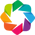

Successfully loaded MSO forecasts with 100 rows
Successfully loaded observed data with 1200 rows
Found 5 forecast files:
 - forecasts_lstm_h2_16_8_a0.1_b0.1_1921_2000.csv
 - forecasts_lstm_h2_32_16_a0.1_b0.1_1921_2000.csv
 - forecasts_lstm_h3_16_8_4_a0.1_b0.1_1921_2000.csv
 - forecasts_lstm_h3_32_16_8_a0.1_b0.1_1921_2000.csv
 - forecasts_lstm_h3_64_32_16_a0.1_b0.1_1921_2000.csv

Attempting to load any available forecast files...
Successfully loaded forecasts for lstm_h2_16_8_a0.1_b0.1_1921_2000
Successfully loaded forecasts for lstm_h2_32_16_a0.1_b0.1_1921_2000
Successfully loaded forecasts for lstm_h3_16_8_4_a0.1_b0.1_1921_2000
Successfully loaded forecasts for lstm_h3_32_16_8_a0.1_b0.1_1921_2000
Successfully loaded forecasts for lstm_h3_64_32_16_a0.1_b0.1_1921_2000

Data loading summary:
MSO data: ✓
Observed data: ✓
WYT data: ✓
Forecast models: 5
Launching server at http://localhost:59147


In [13]:
import pandas as pd
import numpy as np
import panel as pn
import holoviews as hv
from sklearn.metrics import r2_score, mean_absolute_error
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, Legend
import matplotlib.pyplot as plt
import os
from glob import glob

# Enable extensions
hv.extension('bokeh')

# Define LSTM architectures for naming (updated to the 5 selected models)
lstm_architectures = [
    [64, 32, 16],  # Original architecture
    [32, 16, 8],   # Simpler 3-layer
    [16, 8, 4],    # Simpler 3-layer
    [32, 16],      # 2-layer
    [16, 8],       # 2-layer
]

# Define the training/test cutoff year
TRAINING_CUTOFF_YEAR = 1999

def get_model_name(architecture):
    """Generate consistent model name"""
    arch_str = f"h{len(architecture)}_" + "_".join(map(str, architecture))
    return f"lstm_{arch_str}_a0.1_b0.1"

def find_forecast_files():
    """Find all available forecast CSV files"""
    forecast_files = glob("forecasts_*.csv") + glob("*/forecasts_*.csv")
    print(f"Found {len(forecast_files)} forecast files:")
    for file in forecast_files:
        print(f" - {file}")
    return forecast_files

def load_data():
    """Load all necessary data files"""
    # Status tracking for loaded data
    loaded_data = {
        "MSO": False,
        "Observed": False,
        "WYT": False,
        "Forecasts": 0
    }
    
    # Load MSO data
    try:
        mso_df = pd.read_csv('MSO_forecast_9.csv')
        print(f"Successfully loaded MSO forecasts with {len(mso_df)} rows")
        loaded_data["MSO"] = True
    except Exception as e:
        print(f"Error loading MSO forecasts: {str(e)}")
        print("Please make sure 'MSO_forecast_9.csv' exists and contains the expected columns.")
        mso_df = pd.DataFrame()  # Empty dataframe as fallback
    
    # Load observed data
    try:
        observed_df = pd.read_csv('Data/Clean/Orov_clean.csv')
        # Convert Date to datetime in observed data
        observed_df['Date'] = pd.to_datetime(observed_df['Date'])
        observed_df['Year'] = observed_df['Date'].dt.year
        observed_df['Month'] = observed_df['Date'].dt.month
        print(f"Successfully loaded observed data with {len(observed_df)} rows")
        loaded_data["Observed"] = True
    except Exception as e:
        print(f"Error loading observed data: {str(e)}")
        print("Please make sure 'Data/Clean/Orov_clean.csv' exists and contains the expected columns.")
        observed_df = pd.DataFrame(columns=['Date', 'Year', 'Month', 'F'])  # Empty dataframe as fallback
    
    # Load WYT data
    try:
        wyt_df = pd.read_csv('WYT.csv')
        wyt_df.columns = wyt_df.columns.str.strip().str.lower()  # Normalize column names
        if 'year' not in wyt_df.columns or 'wyt' not in wyt_df.columns:
            print("Warning: WYT file does not have expected columns. Looking for 'year' and 'wyt'")
            print(f"Available columns: {wyt_df.columns.tolist()}")
        else:
            loaded_data["WYT"] = True
    except Exception as e:
        print(f"Error loading WYT data: {str(e)}")
        wyt_df = pd.DataFrame(columns=['year', 'wyt'])
    
    # Find available forecast files
    available_forecasts = find_forecast_files()
    
    # Load all LSTM forecasts
    lstm_forecasts = {}
    
    # First try to load the files for the specified architectures
    for arch in lstm_architectures:
        model_name = get_model_name(arch)
        forecast_filename = f'forecasts_{model_name}.csv'
        
        # Check if file exists in current directory or any found files
        file_found = False
        for available_file in available_forecasts:
            if os.path.basename(available_file) == forecast_filename:
                forecast_filename = available_file
                file_found = True
                break
        
        if not file_found:
            print(f"Warning: Forecast file for {model_name} not found in the expected location.")
            continue
        
        try:
            df = pd.read_csv(forecast_filename)
            lstm_forecasts[model_name] = df
            loaded_data["Forecasts"] += 1
            print(f"Successfully loaded forecasts for {model_name}")
        except Exception as e:
            print(f"Error loading {forecast_filename}: {str(e)}")
    
    # If no forecasts were loaded using the architecture names, try to load any available forecast files
    if not lstm_forecasts and available_forecasts:
        print("\nAttempting to load any available forecast files...")
        for file_path in available_forecasts:
            try:
                # Extract model name from filename
                filename = os.path.basename(file_path)
                if filename.startswith('forecasts_') and filename.endswith('.csv'):
                    model_name = filename[len('forecasts_'):-4]  # Remove 'forecasts_' prefix and '.csv' suffix
                    
                    df = pd.read_csv(file_path)
                    lstm_forecasts[model_name] = df
                    loaded_data["Forecasts"] += 1
                    print(f"Successfully loaded forecasts for {model_name}")
            except Exception as e:
                print(f"Error loading {file_path}: {str(e)}")
    
    print(f"\nData loading summary:")
    print(f"MSO data: {'✓' if loaded_data['MSO'] else '✗'}")
    print(f"Observed data: {'✓' if loaded_data['Observed'] else '✗'}")
    print(f"WYT data: {'✓' if loaded_data['WYT'] else '✗'}")
    print(f"Forecast models: {loaded_data['Forecasts']}")
    
    return lstm_forecasts, mso_df, observed_df, wyt_df

def calculate_excel_r2(observed_values, forecast_values):
    """Calculate R-squared like Excel's CORREL^2"""
    try:
        if len(observed_values) != len(forecast_values):
            return None
            
        f_mean = np.mean(forecast_values)
        o_mean = np.mean(observed_values)
        
        numerator = sum((f - f_mean) * (o - o_mean) 
                        for f, o in zip(forecast_values, observed_values))
        
        f_variance = sum((f - f_mean) ** 2 for f in forecast_values)
        o_variance = sum((o - o_mean) ** 2 for o in observed_values)
        
        r = numerator / np.sqrt(f_variance * o_variance)
        return r ** 2
    except Exception as e:
        print(f"Error calculating Excel R2: {str(e)}")
        return None

def calculate_custom_loss(observed_values, forecast_values, alpha=0.1, beta=0.1):
    """Calculate the custom loss function with smoothness penalty and monthly weights"""
    try:
        month_weights = np.array([2, 2, 2, 1.5, 1.5, 1, 1, 1, 1])
        
        # MSE component
        mse_loss = np.mean((observed_values - forecast_values) ** 2)
        
        # Smoothness penalty
        smoothness_penalty = np.mean(np.square(forecast_values[1:] - forecast_values[:-1]))
        
        # Monthly weighted loss
        monthly_weight_loss = np.mean(month_weights * np.square(observed_values - forecast_values))
        
        return mse_loss + alpha * smoothness_penalty + beta * monthly_weight_loss
    except Exception as e:
        print(f"Error calculating custom loss: {str(e)}")
        return None

def calculate_percentage_bias(observed_values, forecast_values):
    """Calculate percentage bias"""
    try:
        return 100 * (np.mean(forecast_values) - np.mean(observed_values)) / np.mean(observed_values)
    except Exception as e:
        print(f"Error calculating percentage bias: {str(e)}")
        return None

def create_comparison_plot(lstm_forecasts, mso_df, observed_df, selected_year, wyt_value=None, is_training=None):
    """Create comparison plot with all models using direct Bokeh implementation"""
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
    month_nums = list(range(1, 10))
    
    # Check if required data is available
    if observed_df.empty:
        return pn.pane.Markdown(f"**Error:** Observed data not loaded. Cannot create plot for year {selected_year}.")
    
    # Create a Bokeh figure
    title = f'Flow Comparison for Year {selected_year}'
    if wyt_value:
        title += f' (WYT = {wyt_value})'
    
    # Add period indicator to title
    if is_training is not None:
        period_label = "Training Period" if is_training else "Test Period"
        title += f' - {period_label}'
    
    # Create the plot
    try:
        p = figure(
            width=900, 
            height=500,
            title=title,
            tools="pan,wheel_zoom,box_zoom,reset,save",
            x_range=[0.5, 9.5],  # Slightly expanded range for better visibility
            toolbar_location="above"
        )
        
        # Set background color based on period
        if is_training is not None:
            if is_training:
                p.background_fill_color = "#f5f5ff"  # Light blue for training
            else:
                p.background_fill_color = "#fff5f5"  # Light red for test
        
        # Set up x-axis ticks with month names
        p.xaxis.ticker = month_nums
        p.xaxis.major_label_overrides = {i: m for i, m in zip(month_nums, months)}
        
        # Create hover tool
        hover = HoverTool(
            tooltips=[
                ("Series", "$name"),
                ("Month", "@month"),
                ("Value", "@value{0.0}")
            ],
            line_policy='nearest',
            point_policy='snap_to_data',
            mode='mouse'
        )
        p.add_tools(hover)
        
        legend_items = []
        
        # Add MSO forecast if available
        if not mso_df.empty and selected_year in mso_df['Year'].values:
            try:
                mso_forecast = mso_df[mso_df['Year'] == selected_year].iloc[0]
                mso_values = [float(mso_forecast[month]) for month in months]
                
                # Create MSO data source
                source_mso = ColumnDataSource(data=dict(
                    x=month_nums,
                    value=mso_values,
                    month=months
                ))
                
                # Create MSO line
                r_mso = p.line('x', 'value', source=source_mso, 
                              line_width=2, color='green', line_dash='dotted')
                r_mso.name = "MSO"  # Set name for hover tool
                
                # Add to legend
                legend_items.append(("MSO", [r_mso]))
            except Exception as e:
                print(f"Error adding MSO forecast for year {selected_year}: {str(e)}")
        
        # Get observed data for selected year
        observed_data = observed_df[
            (observed_df['Year'] == selected_year) & 
            (observed_df['Month'].isin(range(1, 10)))
        ]
        
        # Add observed data if available
        if not observed_data.empty:
            try:
                # Prepare observed values (handle missing months)
                observed_values = []
                for m in month_nums:
                    month_data = observed_data[observed_data['Month'] == m]
                    if not month_data.empty:
                        observed_values.append(float(month_data['F'].values[0]))
                    else:
                        observed_values.append(float('nan'))
                
                # Create observed data source
                source_obs = ColumnDataSource(data=dict(
                    x=month_nums,
                    value=observed_values,
                    month=months
                ))
                
                # Create observed line
                r_obs = p.line('x', 'value', source=source_obs, 
                              line_width=3, color='red')
                r_obs.name = "Observed"  # Set name for hover tool
                
                # Add to legend
                legend_items.append(("Observed", [r_obs]))
            except Exception as e:
                print(f"Error adding observed data for year {selected_year}: {str(e)}")
        
        # Add LSTM models
        if lstm_forecasts:
            colors = plt.cm.rainbow(np.linspace(0, 1, len(lstm_forecasts)))
            
            for (model_name, lstm_df), color in zip(lstm_forecasts.items(), colors):
                try:
                    if selected_year not in lstm_df['Year'].values:
                        print(f"Warning: Year {selected_year} not found in {model_name} forecasts")
                        continue
                        
                    lstm_forecast = lstm_df[lstm_df['Year'] == selected_year].iloc[0]
                    
                    # Check if F_month columns exist
                    f_columns = [f'F_{month}' for month in months]
                    missing_columns = [col for col in f_columns if col not in lstm_forecast.index]
                    if missing_columns:
                        print(f"Warning: {model_name} is missing columns: {missing_columns}")
                        continue
                        
                    lstm_values = [float(lstm_forecast[f'F_{m}']) for m in months]
                    
                    # Create LSTM data source
                    source_lstm = ColumnDataSource(data=dict(
                        x=month_nums,
                        value=lstm_values,
                        month=months
                    ))
                    
                    # Create LSTM line with unique color
                    hex_color = rgb_to_hex(color)
                    r_lstm = p.line('x', 'value', source=source_lstm, 
                                  line_width=2, color=hex_color, line_dash='dashed')
                    r_lstm.name = model_name  # Set name for hover tool
                    
                    # Add to legend
                    legend_items.append((model_name, [r_lstm]))
                except Exception as e:
                    print(f"Error adding {model_name} for year {selected_year}: {str(e)}")
        
        # Add legend if we have any items
        if legend_items:
            legend = Legend(items=legend_items)
            legend.click_policy = "hide"  # Allow toggling lines by clicking legend
            p.add_layout(legend, 'right')
        
        # Format the plot
        p.grid.grid_line_alpha = 0.3
        p.y_range.start = 0  # Start y-axis at 0
        p.yaxis.axis_label = "Flow"
        p.xaxis.axis_label = "Month"
        
        # Create a Panel pane from the Bokeh figure
        return pn.pane.Bokeh(p)
        
    except Exception as e:
        error_message = f"Error creating plot for year {selected_year}: {str(e)}"
        print(error_message)
        return pn.pane.Markdown(f"**Error:** {error_message}")

def calculate_all_metrics(lstm_forecasts, mso_df, observed_df, selected_year):
    """Calculate all metrics for each model"""
    try:
        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
        metrics_text = []
        
        # Check if observed data is available
        observed_data = observed_df[
            (observed_df['Year'] == selected_year) & 
            (observed_df['Month'].isin(range(1, 10)))
        ]
        
        if observed_data.empty:
            return "**Metrics:** No observed data available for this year."
        
        observed_values = np.array(observed_data['F'].values)
        
        # Check if we have complete data (9 months)
        if len(observed_values) != 9:
            return f"**Metrics:** Incomplete observed data for this year ({len(observed_values)}/9 months)."
        
        # Calculate MSO metrics if available
        if not mso_df.empty and selected_year in mso_df['Year'].values:
            try:
                mso_forecast = mso_df[mso_df['Year'] == selected_year].iloc[0]
                mso_values = np.array([float(mso_forecast[month]) for month in months])
                
                mso_metrics = {
                    'Excel R²': calculate_excel_r2(observed_values, mso_values),
                    'Sklearn R²': r2_score(observed_values, mso_values),
                    'MAE': mean_absolute_error(observed_values, mso_values),
                    'Custom Loss': calculate_custom_loss(observed_values, mso_values),
                    'Percentage Bias': calculate_percentage_bias(observed_values, mso_values)
                }
                
                # Filter out None values
                mso_metrics = {k: v for k, v in mso_metrics.items() if v is not None}
                
                if mso_metrics:
                    metrics_text.append("**MSO Metrics:**\n" + 
                                       " | ".join([f"{k}: {v:.2f}" for k, v in mso_metrics.items()]))
                else:
                    metrics_text.append("**MSO Metrics:** Error calculating metrics.")
            except Exception as e:
                metrics_text.append(f"**MSO Metrics:** Error: {str(e)}")
        
        # Calculate LSTM metrics
        for model_name, lstm_df in lstm_forecasts.items():
            try:
                # Skip if this year doesn't exist in the forecast data
                if selected_year not in lstm_df['Year'].values:
                    metrics_text.append(f"**{model_name} Metrics:** No forecast available for this year.")
                    continue
                
                lstm_forecast = lstm_df[lstm_df['Year'] == selected_year].iloc[0]
                
                # Check if F_month columns exist
                f_columns = [f'F_{month}' for month in months]
                if not all(col in lstm_forecast.index for col in f_columns):
                    metrics_text.append(f"**{model_name} Metrics:** Incomplete forecast data for this year.")
                    continue
                
                lstm_values = np.array([float(lstm_forecast[f'F_{month}']) for month in months])
                
                model_metrics = {
                    'Excel R²': calculate_excel_r2(observed_values, lstm_values),
                    'Sklearn R²': r2_score(observed_values, lstm_values),
                    'MAE': mean_absolute_error(observed_values, lstm_values),
                    'Custom Loss': calculate_custom_loss(observed_values, lstm_values),
                    'Percentage Bias': calculate_percentage_bias(observed_values, lstm_values)
                }
                
                # Filter out None values
                model_metrics = {k: v for k, v in model_metrics.items() if v is not None}
                
                if model_metrics:
                    metrics_text.append(f"**{model_name} Metrics:**\n" + 
                                      " | ".join([f"{k}: {v:.2f}" for k, v in model_metrics.items()]))
                else:
                    metrics_text.append(f"**{model_name} Metrics:** Error calculating metrics.")
            except Exception as e:
                metrics_text.append(f"**{model_name} Metrics:** Error: {str(e)}")
        
        return "\n\n".join(metrics_text)
    except Exception as e:
        print(f"Detailed error calculating metrics: {str(e)}")
        return f"**Metrics:** Error calculating metrics: {str(e)}"

def rgb_to_hex(rgba_color):
    """Convert RGB(A) color to hex"""
    try:
        rgb = tuple(int(x * 255) for x in rgba_color[:3])
        return '#{:02x}{:02x}{:02x}'.format(*rgb)
    except Exception as e:
        print(f"Error converting color: {str(e)}")
        return '#000000'  # Default to black on error

def get_common_years(lstm_forecasts, mso_df, observed_df):
    """Get years common to all datasets, with fallbacks for missing data"""
    try:
        # Start with all years from observed data
        if not observed_df.empty and 'Year' in observed_df.columns:
            all_years = set(observed_df['Year'].unique())
        else:
            # Fallback to years 1921-2021 if no observed data
            all_years = set(range(1921, 2022))
        
        # Intersect with MSO years if available
        if not mso_df.empty and 'Year' in mso_df.columns:
            mso_years = set(mso_df['Year'])
            all_years = all_years.intersection(mso_years)
        
        # Intersect with LSTM years if available
        if lstm_forecasts:
            for model_name, df in lstm_forecasts.items():
                if 'Year' in df.columns:
                    model_years = set(df['Year'].unique())
                    all_years = all_years.intersection(model_years)
        
        # Sort years for display
        return sorted(list(all_years))
    except Exception as e:
        print(f"Error getting common years: {str(e)}")
        # Fallback to limited year range if error occurs
        return list(range(1950, 2022))

def create_dashboard():
    """Create the main dashboard"""
    # Load data
    lstm_forecasts, mso_df, observed_df, wyt_df = load_data()
    
    # Create containers
    plots_container = pn.Column()
    
    # Get common years across all models (with error handling)
    years = get_common_years(lstm_forecasts, mso_df, observed_df)
    
    # Inform if no years found
    if not years:
        plots_container.append(pn.pane.Markdown("**Error:** No common years found across datasets."))
        years = list(range(1950, 2022))  # Fallback for UI to work
    
    # Split years into training and test sets
    training_years = [y for y in years if y <= TRAINING_CUTOFF_YEAR]
    test_years = [y for y in years if y > TRAINING_CUTOFF_YEAR]
    
    # Prepare water year type options
    wyt_options = ['C', 'D', 'BN', 'AN', 'W']
    if not wyt_df.empty and 'wyt' in wyt_df.columns:
        available_wyt = sorted(wyt_df['wyt'].unique())
        if len(available_wyt) > 0:
            wyt_options = available_wyt
    
    # Create period selector
    period_select = pn.widgets.RadioButtonGroup(
        name='Dataset Period',
        options=['All', 'Training', 'Test'],
        value='All',
        button_type='success'
    )
    
    # Create water year type selector
    wyt_select = pn.widgets.MultiChoice(
        name='Select Water Year Types',
        options=wyt_options,
        value=[],
        height=100
    )
    
    # Create year selector (will be updated based on WYT and period selection)
    year_select = pn.widgets.MultiChoice(
        name='Select Years',
        options=list(map(str, years)),
        value=[str(years[-1])] if years else [],
        height=300
    )
    
    # Create data status indicator (without style parameter)
    data_status_text = f"""
    ### Data Status:
    - **Observed Data:** {'✓ Loaded' if not observed_df.empty else '✗ Missing'}
    - **MSO Forecasts:** {'✓ Loaded' if not mso_df.empty else '✗ Missing'}
    - **WYT Data:** {'✓ Loaded' if not wyt_df.empty else '✗ Missing'}
    - **LSTM Models:** {'✓ Loaded ' + str(len(lstm_forecasts)) + ' models' if lstm_forecasts else '✗ Missing'}
    """
    data_status = pn.pane.Markdown(data_status_text)
    
    def update_year_options(event):
        # Get selected period
        selected_period = period_select.value
        
        # Filter years based on period
        if selected_period == 'Training':
            period_filtered_years = training_years
        elif selected_period == 'Test':
            period_filtered_years = test_years
        else:  # 'All'
            period_filtered_years = years
        
        # Filter years based on selected water year types
        selected_wyt = wyt_select.value
        
        if not selected_wyt or wyt_df.empty or 'wyt' not in wyt_df.columns:
            # If no WYT selected or no WYT data, show all years for the selected period
            filtered_years = period_filtered_years
        else:
            try:
                # Filter years by selected WYT
                wyt_filtered_years = wyt_df[wyt_df['wyt'].isin(selected_wyt)]['year'].astype(int).tolist()
                # Only keep years that exist in our dataset and the selected period
                filtered_years = sorted(list(set(wyt_filtered_years).intersection(set(period_filtered_years))))
            except Exception as e:
                print(f"Error filtering years by WYT: {str(e)}")
                filtered_years = period_filtered_years
        
        # Update year selector options
        year_select.options = list(map(str, filtered_years))
        
        # If current selection is not in filtered options, select the most recent year
        if not set(year_select.value).intersection(set(year_select.options)) and year_select.options:
            year_select.value = [year_select.options[-1]]
        elif not year_select.options:
            year_select.value = []
    
    def update_plots(event):
        # Clear the container
        plots_container.clear()
        
        # Add warning if data is missing
        if observed_df.empty:
            plots_container.append(pn.pane.Markdown("⚠️ **Warning:** Observed data is missing. Plots may not display correctly."))
        
        if not lstm_forecasts:
            plots_container.append(pn.pane.Markdown("⚠️ **Warning:** No forecast models were found. Please run the forecast generation code first."))
        
        # Get selected period for visual indication
        selected_period = period_select.value
        
        # Handle no years selected
        if not year_select.value:
            plots_container.append(pn.pane.Markdown("**No years selected.** Please select at least one year to display."))
            return
        
        # Create plots for each selected year
        for year_str in year_select.value:
            try:
                year = int(year_str)
                
                # Determine if this year is in training or test set
                is_training = None
                if selected_period != 'All':
                    is_training = year <= TRAINING_CUTOFF_YEAR
                
                # Get WYT for this year if available
                wyt_value = None
                if not wyt_df.empty and 'year' in wyt_df.columns and 'wyt' in wyt_df.columns:
                    year_wyt = wyt_df[wyt_df['year'] == year]['wyt'].values
                    if len(year_wyt) > 0:
                        wyt_value = year_wyt[0]
                
                # Create plot with WYT in title if available
                plot = create_comparison_plot(lstm_forecasts, mso_df, observed_df, year, wyt_value, is_training)
                
                # Calculate metrics
                metrics_text = calculate_all_metrics(lstm_forecasts, mso_df, observed_df, year)
                
                # Create period indicator without style parameter
                if selected_period != 'All':
                    period_indicator = "## <span style='color:blue;'>Training Period (≤ 1999)</span>" if is_training else "## <span style='color:red;'>Test Period (≥ 2000)</span>"
                else:
                    period_indicator = "## <span style='color:blue;'>Training Period (≤ 1999)</span>" if year <= TRAINING_CUTOFF_YEAR else "## <span style='color:red;'>Test Period (≥ 2000)</span>"
                
                # Add to container (using HTML in Markdown instead of style parameter)
                plots_container.extend([
                    pn.pane.Markdown(period_indicator),
                    plot,
                    pn.pane.Markdown(metrics_text),
                    pn.layout.Divider()
                ])
            except Exception as e:
                plots_container.append(pn.pane.Markdown(f"**Error creating plot for year {year_str}:** {str(e)}"))
    
    # Set up the callbacks
    period_select.param.watch(update_year_options, 'value')
    wyt_select.param.watch(update_year_options, 'value')
    year_select.param.watch(update_plots, 'value')
    
    # Initial update
    update_year_options(None)
    update_plots(None)
    
    # Create period stats pane to show counts (without style parameter)
    period_stats_text = f"""
    ### Dataset Period Counts:
    - **Training Period (≤ 1999):** {len(training_years)} years
    - **Test Period (≥ 2000):** {len(test_years)} years
    - **Total:** {len(years)} years
    """
    period_stats_pane = pn.pane.Markdown(period_stats_text)
    
    # Create layout
    dashboard = pn.Column(
        "## Flow Forecast Comparison",
        pn.Row(
            pn.Column(
                "### Select Dataset Period", 
                period_select,
                period_stats_pane,
                data_status,
                "### Select Water Year Types", 
                wyt_select,
                "### Select Years", 
                year_select, 
                width=300
            ),
            plots_container
        )
    )
    
    return dashboard

if __name__ == "__main__":
    # Create and display the dashboard
    dashboard = create_dashboard()
    pn.serve(dashboard)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
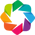

Launching server at http://localhost:58243


In [30]:
import pandas as pd
import numpy as np
import panel as pn
import holoviews as hv
from sklearn.metrics import r2_score, mean_absolute_error
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, Legend
import matplotlib.pyplot as plt

# Enable extensions
hv.extension('bokeh')

# Define LSTM architectures for naming
lstm_architectures = [
    [64, 32, 16],  # Original architecture
    [32, 16, 8],   # Simpler 3-layer
    [16, 8, 4],    # Simpler 3-layer
    [8, 4, 2],     # Simpler 3-layer
    [32, 16],      # 2-layer
    [16, 8],       # 2-layer
    [8, 4],        # 2-layer
    [4, 2]         # 2-layer
]

def get_model_name(architecture):
    """Generate consistent model name"""
    arch_str = f"h{len(architecture)}_" + "_".join(map(str, architecture))
    return f"lstm_{arch_str}_a0.1_b0.1"

def load_data():
    """Load all necessary data files"""
    # Load MSO and observed data
    mso_df = pd.read_csv('MSO_forecast_9.csv')
    observed_df = pd.read_csv('Data/Clean/Orov_clean.csv')
    
    # Load WYT data
    try:
        wyt_df = pd.read_csv('WYT.csv')
        wyt_df.columns = wyt_df.columns.str.strip().str.lower()  # Normalize column names
        if 'year' not in wyt_df.columns or 'wyt' not in wyt_df.columns:
            print("Warning: WYT file does not have expected columns. Looking for 'year' and 'wyt'")
            print(f"Available columns: {wyt_df.columns.tolist()}")
    except Exception as e:
        print(f"Error loading WYT data: {str(e)}")
        wyt_df = pd.DataFrame(columns=['year', 'wyt'])
    
    # Load all LSTM forecasts
    lstm_forecasts = {}
    for arch in lstm_architectures:
        model_name = get_model_name(arch)
        try:
            df = pd.read_csv(f'forecasts_{model_name}.csv')
            lstm_forecasts[model_name] = df
        except Exception as e:
            print(f"Error loading {model_name}: {str(e)}")
    
    # Convert Date to datetime in observed data
    observed_df['Date'] = pd.to_datetime(observed_df['Date'])
    observed_df['Year'] = observed_df['Date'].dt.year
    observed_df['Month'] = observed_df['Date'].dt.month
    
    return lstm_forecasts, mso_df, observed_df, wyt_df

def calculate_excel_r2(observed_values, forecast_values):
    """Calculate R-squared like Excel's CORREL^2"""
    if len(observed_values) != len(forecast_values):
        return None
        
    f_mean = np.mean(forecast_values)
    o_mean = np.mean(observed_values)
    
    numerator = sum((f - f_mean) * (o - o_mean) 
                    for f, o in zip(forecast_values, observed_values))
    
    f_variance = sum((f - f_mean) ** 2 for f in forecast_values)
    o_variance = sum((o - o_mean) ** 2 for o in observed_values)
    
    r = numerator / np.sqrt(f_variance * o_variance)
    return r ** 2

def calculate_custom_loss(observed_values, forecast_values, alpha=0.1, beta=0.1):
    """Calculate the custom loss function with smoothness penalty and monthly weights"""
    month_weights = np.array([2, 2, 2, 1.5, 1.5, 1, 1, 1, 1])
    
    # MSE component
    mse_loss = np.mean((observed_values - forecast_values) ** 2)
    
    # Smoothness penalty
    smoothness_penalty = np.mean(np.square(forecast_values[1:] - forecast_values[:-1]))
    
    # Monthly weighted loss
    monthly_weight_loss = np.mean(month_weights * np.square(observed_values - forecast_values))
    
    return mse_loss + alpha * smoothness_penalty + beta * monthly_weight_loss

def calculate_percentage_bias(observed_values, forecast_values):
    """Calculate percentage bias"""
    return 100 * (np.mean(forecast_values) - np.mean(observed_values)) / np.mean(observed_values)

def create_comparison_plot(lstm_forecasts, mso_df, observed_df, selected_year, wyt_value=None):
    """Create comparison plot with all models using direct Bokeh implementation"""
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
    month_nums = list(range(1, 10))
    
    # Create a Bokeh figure
    title = f'Flow Comparison for Year {selected_year}'
    if wyt_value:
        title += f' (WYT = {wyt_value})'
        
    p = figure(
        width=900, 
        height=500,
        title=title,
        tools="pan,wheel_zoom,box_zoom,reset,save",
        x_range=[0.5, 9.5],  # Slightly expanded range for better visibility
        toolbar_location="above"
    )
    
    # Set up x-axis ticks with month names
    p.xaxis.ticker = month_nums
    p.xaxis.major_label_overrides = {i: m for i, m in zip(month_nums, months)}
    
    # Create hover tool
    hover = HoverTool(
        tooltips=[
            ("Series", "$name"),
            ("Month", "@month"),
            ("Value", "@value{0.0}")
        ],
        line_policy='nearest',
        point_policy='snap_to_data',
        mode='mouse'
    )
    p.add_tools(hover)
    
    # Get MSO forecast for selected year
    mso_forecast = mso_df[mso_df['Year'] == selected_year].iloc[0]
    mso_values = [float(mso_forecast[month]) for month in months]
    
    # Create MSO data source
    source_mso = ColumnDataSource(data=dict(
        x=month_nums,
        value=mso_values,
        month=months
    ))
    
    # Create MSO line
    r_mso = p.line('x', 'value', source=source_mso, 
                  line_width=2, color='green', line_dash='dotted')
    r_mso.name = "MSO"  # Set name for hover tool
    
    # Get observed data for selected year
    observed_data = observed_df[
        (observed_df['Year'] == selected_year) & 
        (observed_df['Month'].isin(range(1, 10)))
    ]
    
    # Prepare observed values (handle missing months)
    observed_values = []
    for m in month_nums:
        month_data = observed_data[observed_data['Month'] == m]
        if not month_data.empty:
            observed_values.append(float(month_data['F'].values[0]))
        else:
            observed_values.append(float('nan'))
    
    # Create observed data source
    source_obs = ColumnDataSource(data=dict(
        x=month_nums,
        value=observed_values,
        month=months
    ))
    
    # Create observed line
    r_obs = p.line('x', 'value', source=source_obs, 
                  line_width=3, color='red')
    r_obs.name = "Observed"  # Set name for hover tool
    
    # Add LSTM models
    legend_items = [("Observed", [r_obs]), ("MSO", [r_mso])]
    colors = plt.cm.rainbow(np.linspace(0, 1, len(lstm_forecasts)))
    
    for (model_name, lstm_df), color in zip(lstm_forecasts.items(), colors):
        lstm_forecast = lstm_df[lstm_df['Year'] == selected_year].iloc[0]
        lstm_values = [float(lstm_forecast[f'F_{m}']) for m in months]
        
        # Create LSTM data source
        source_lstm = ColumnDataSource(data=dict(
            x=month_nums,
            value=lstm_values,
            month=months
        ))
        
        # Create LSTM line with unique color
        hex_color = rgb_to_hex(color)
        r_lstm = p.line('x', 'value', source=source_lstm, 
                       line_width=2, color=hex_color, line_dash='dashed')
        r_lstm.name = model_name  # Set name for hover tool
        
        # Add to legend
        legend_items.append((model_name, [r_lstm]))
    
    # Add legend
    legend = Legend(items=legend_items)
    legend.click_policy = "hide"  # Allow toggling lines by clicking legend
    p.add_layout(legend, 'right')
    
    # Format the plot
    p.grid.grid_line_alpha = 0.3
    p.y_range.start = 0  # Start y-axis at 0
    p.yaxis.axis_label = "Flow"
    p.xaxis.axis_label = "Month"
    
    # Create a Panel pane from the Bokeh figure
    return pn.pane.Bokeh(p)

def calculate_all_metrics(lstm_forecasts, mso_df, observed_df, selected_year):
    """Calculate all metrics for each model"""
    try:
        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
        
        # Get MSO forecast
        mso_forecast = mso_df[mso_df['Year'] == selected_year].iloc[0]
        mso_values = np.array([float(mso_forecast[month]) for month in months])  # Convert to float array
        
        # Get observed values
        observed_values = np.array(observed_df[
            (observed_df['Year'] == selected_year) & 
            (observed_df['Month'].isin(range(1, 10)))
        ]['F'].values)  # Convert to array
        
        metrics_text = []
        
        # Calculate MSO metrics
        mso_metrics = {
            'Excel R²': calculate_excel_r2(observed_values, mso_values),
            'Sklearn R²': r2_score(observed_values, mso_values),
            'MAE': mean_absolute_error(observed_values, mso_values),
            'Custom Loss': calculate_custom_loss(observed_values, mso_values),
            'Percentage Bias': calculate_percentage_bias(observed_values, mso_values)
        }
        metrics_text.append("**MSO Metrics:**\n" + 
                          " | ".join([f"{k}: {v:.2f}" for k, v in mso_metrics.items()]))
        
        # Calculate LSTM metrics
        for model_name, lstm_df in lstm_forecasts.items():
            lstm_forecast = lstm_df[lstm_df['Year'] == selected_year].iloc[0]
            lstm_values = np.array([float(lstm_forecast[f'F_{month}']) for month in months])  # Convert to float array
            
            model_metrics = {
                'Excel R²': calculate_excel_r2(observed_values, lstm_values),
                'Sklearn R²': r2_score(observed_values, lstm_values),
                'MAE': mean_absolute_error(observed_values, lstm_values),
                'Custom Loss': calculate_custom_loss(observed_values, lstm_values),
                'Percentage Bias': calculate_percentage_bias(observed_values, lstm_values)
            }
            metrics_text.append(f"**{model_name} Metrics:**\n" + 
                              " | ".join([f"{k}: {v:.2f}" for k, v in model_metrics.items()]))
        
        return "\n\n".join(metrics_text)
    except Exception as e:
        print(f"Detailed error: {str(e)}")  # Add detailed error printing
        return f"**Metrics:** Error calculating metrics: {str(e)}"

def rgb_to_hex(rgba_color):
    """Convert RGB(A) color to hex"""
    rgb = tuple(int(x * 255) for x in rgba_color[:3])
    return '#{:02x}{:02x}{:02x}'.format(*rgb)

def create_dashboard():
    """Create the main dashboard"""
    # Load data
    lstm_forecasts, mso_df, observed_df, wyt_df = load_data()
    
    # Create containers
    plots_container = pn.Column()
    
    # Get common years across all models
    years = sorted(list(set.intersection(*[
        set(df['Year'].unique()) for df in lstm_forecasts.values()
    ])))
    
    # Prepare water year type options
    wyt_options = ['C', 'D', 'BN', 'AN', 'W']
    if not wyt_df.empty:
        available_wyt = sorted(wyt_df['wyt'].unique())
        if len(available_wyt) > 0:
            wyt_options = available_wyt
    
    # Create water year type selector
    wyt_select = pn.widgets.MultiChoice(
        name='Select Water Year Types',
        options=wyt_options,
        value=[],
        height=100
    )
    
    # Create year selector (will be updated based on WYT selection)
    year_select = pn.widgets.MultiChoice(
        name='Select Years',
        options=list(map(str, years)),
        value=[str(years[-1])],
        height=300
    )
    
    def update_year_options(event):
        # Filter years based on selected water year types
        selected_wyt = wyt_select.value
        
        if not selected_wyt or wyt_df.empty:
            # If no WYT selected or no WYT data, show all years
            filtered_years = years
        else:
            # Filter years by selected WYT
            filtered_years = wyt_df[wyt_df['wyt'].isin(selected_wyt)]['year'].astype(int).tolist()
            # Only keep years that exist in our dataset
            filtered_years = sorted(list(set(filtered_years).intersection(set(years))))
        
        # Update year selector options
        year_select.options = list(map(str, filtered_years))
        
        # If current selection is not in filtered options, select the most recent year
        if not set(year_select.value).intersection(set(year_select.options)) and year_select.options:
            year_select.value = [year_select.options[-1]]
        elif not year_select.options:
            year_select.value = []
    
    def update_plots(event):
        # Clear the container
        plots_container.clear()
        
        # Create plots for each selected year
        for year_str in year_select.value:
            year = int(year_str)
            
            # Get WYT for this year if available
            wyt_value = None
            if not wyt_df.empty:
                year_wyt = wyt_df[wyt_df['year'] == year]['wyt'].values
                if len(year_wyt) > 0:
                    wyt_value = year_wyt[0]
            
            # Create plot with WYT in title if available
            plot = create_comparison_plot(lstm_forecasts, mso_df, observed_df, year, wyt_value)
            
            # Calculate metrics
            metrics_text = calculate_all_metrics(lstm_forecasts, mso_df, observed_df, year)
            
            # Add to container
            plots_container.extend([
                plot,
                pn.pane.Markdown(metrics_text),
                pn.layout.Divider()
            ])
    
    # Set up the callbacks
    wyt_select.param.watch(update_year_options, 'value')
    year_select.param.watch(update_plots, 'value')
    
    # Initial update
    update_year_options(None)
    update_plots(None)
    
    # Create layout
    dashboard = pn.Column(
        "## Flow Forecast Comparison",
        pn.Row(
            pn.Column(
                "### Select Water Year Types", 
                wyt_select,
                "### Select Years", 
                year_select, 
                width=300
            ),
            plots_container
        )
    )
    
    return dashboard

if __name__ == "__main__":
    # Create and display the dashboard
    dashboard = create_dashboard()
    pn.serve(dashboard)

Explained variance ratio by component:
PC1: 0.7200
PC2: 0.1984
PC3: 0.0756
PC4: 0.0060

Cumulative explained variance ratio:
PC1 to PC1: 0.7200
PC1 to PC2: 0.9183
PC1 to PC3: 0.9940
PC1 to PC4: 1.0000

Component loadings:
        PC1       PC2       PC3       PC4
T  0.536456  0.435277  0.172103 -0.702232
V  0.546303  0.372224  0.246869  0.708561
P -0.508237  0.255190  0.822043 -0.028612
F -0.394289  0.779013 -0.483406  0.063187


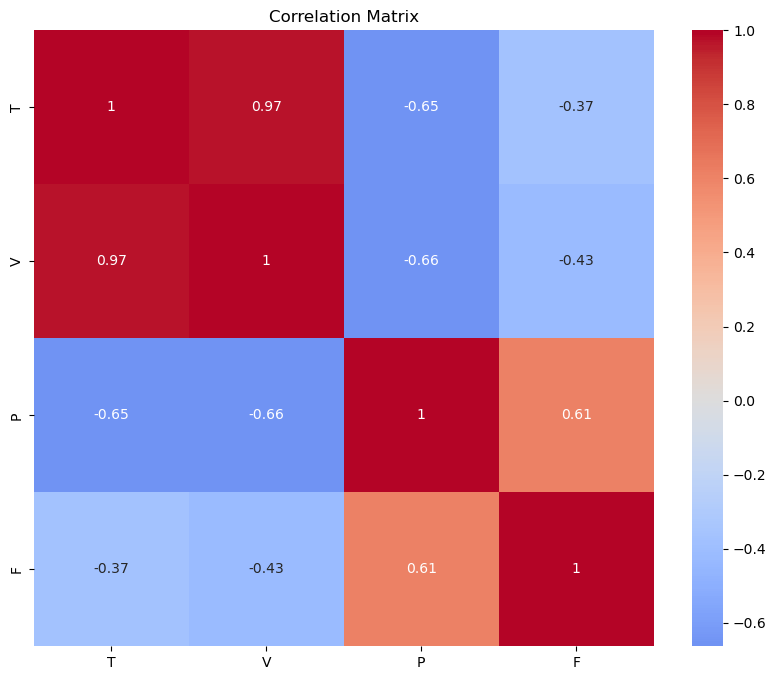

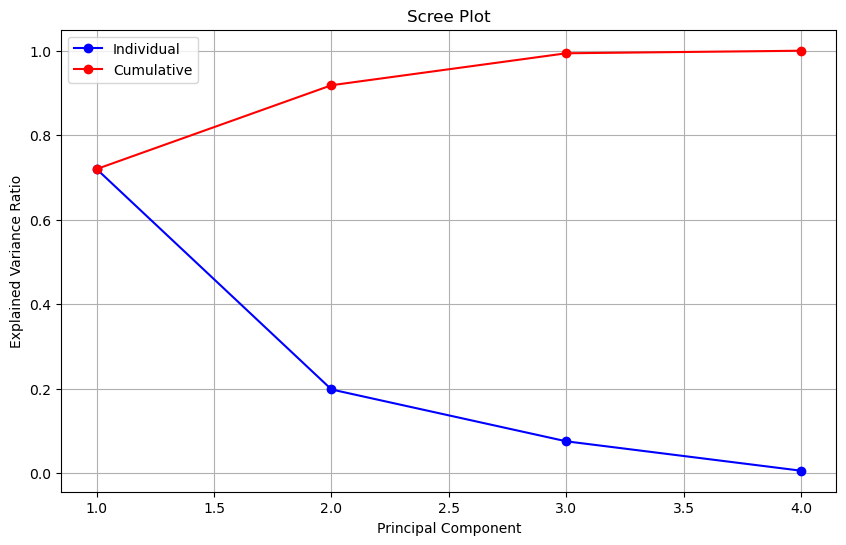

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Your data is already loaded as df with columns ['Date', 'T', 'V', 'P', 'F']
# Extract features for PCA
features = ['T', 'V', 'P', 'F']
X = df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create PCA instance
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Print results
print("Explained variance ratio by component:")
for i, var in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {var:.4f}")

print("\nCumulative explained variance ratio:")
for i, var in enumerate(cumulative_variance_ratio):
    print(f"PC1 to PC{i+1}: {var:.4f}")

# Get component loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(features))],
    index=features
)
print("\nComponent loadings:")
print(loadings)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-')
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'ro-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend(['Individual', 'Cumulative'])
plt.grid(True)
plt.show()

# Save PCA results if needed
pca_results = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(len(features))])
pca_results['Date'] = df['Date']

In [ ]:
def create_custom_flow_loss(alpha, beta):
    def custom_flow_loss(y_true, y_pred):
        month_weights = tf.constant([2, 2, 2, 1.5, 1.5, 1, 1, 1, 1])
        mse_loss = tf.keras.losses.MSE(y_true, y_pred)
        
        smoothness_penalty = tf.reduce_mean(tf.square(y_pred[:, 1:] - y_pred[:, :-1]))
        monthly_weight_loss = tf.reduce_mean(month_weights * tf.square(y_true - y_pred))
        
        return mse_loss + alpha * smoothness_penalty + beta * monthly_weight_loss
    return custom_flow_loss

In [10]:
"""
Model Configuration Parameters:

alpha (Smoothness weight):
- Range: 0.0 to 1.0
- alpha = 0.0: No smoothness constraint
- alpha = 0.1: Mild smoothness
- alpha > 0.3: Strong smoothness constraint
- Controls how much to penalize large changes between consecutive predictions

beta (Monthly weights importance):
- Range: 0.0 to 1.0
- beta = 0.0: No monthly weighting (all months equally important)
- beta = 0.2: Moderate monthly weighting
- beta > 0.4: Strong emphasis on monthly weights
- Controls how much to emphasize the Jan-Sep prediction accuracy
"""

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt

# Define all possible parameter combinations
configurations = [
    # Varying alpha with beta=0
    {'alpha': 0.0, 'beta': 0.0, 'attention': True},
    {'alpha': 0.1, 'beta': 0.0, 'attention': True},
    {'alpha': 0.3, 'beta': 0.0, 'attention': True},
    
    # Varying beta with alpha=0
    {'alpha': 0.0, 'beta': 0.0, 'attention': True},
    {'alpha': 0.0, 'beta': 0.2, 'attention': True},
    {'alpha': 0.0, 'beta': 0.4, 'attention': True},
    
    # Baseline configuration
    {'alpha': 0.0, 'beta': 0.0, 'attention': True},
    
    # Without attention
    {'alpha': 0.0, 'beta': 0.0, 'attention': False}
]

class TemporalAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(TemporalAttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        initial_weights = tf.concat([
            tf.ones([9]),
            tf.ones([3]) * 2.0
        ], axis=0)
        self.attention_weights = self.add_weight(
            name='attention_weights',
            shape=(12,),
            initializer=lambda shape, dtype: initial_weights,
            trainable=True
        )
        
    def call(self, inputs):
        return inputs * tf.reshape(self.attention_weights, [1, 12, 1])

def create_custom_flow_loss(alpha, beta):
    def custom_flow_loss(y_true, y_pred):
        month_weights = tf.constant([1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5])
        y_pred_non_neg = tf.maximum(y_pred, 0)
        mse_loss = tf.keras.losses.MSE(y_true, y_pred_non_neg)
        
        smoothness_penalty = tf.reduce_mean(tf.square(y_pred_non_neg[:, 1:] - y_pred_non_neg[:, :-1]))
        monthly_weight_loss = tf.reduce_mean(month_weights * tf.square(y_true - y_pred_non_neg))
        
        return mse_loss + alpha * smoothness_penalty + beta * monthly_weight_loss
    return custom_flow_loss

def create_sequences(data, input_window=12, output_window=9):
    X, y = [], []
    total_window = input_window + output_window
    for i in range(len(data) - total_window + 1):
        X.append(data[i:(i + input_window)])
        y.append(data[(i + input_window):(i + input_window + output_window), -1])
    return np.array(X), np.array(y)

def build_lstm_model(input_window, n_features, output_window=9, use_attention=True):
    layers = []
    if use_attention:
        layers.append(TemporalAttentionLayer(input_shape=(input_window, n_features)))
    else:
        layers.append(LSTM(128, activation='tanh', return_sequences=True, 
                         input_shape=(input_window, n_features)))
    
    layers.extend([
        BatchNormalization(),
        LSTM(64, activation='tanh', return_sequences=True),
        BatchNormalization(),
        LSTM(32, activation='tanh'),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(output_window)
    ])
    
    return Sequential(layers)

# Main training loop
input_window = 12
output_window = 9
n_features = X_combined.shape[1]
X, y = create_sequences(X_combined, input_window, output_window)

# Train models with different configurations
for config in configurations:
    print(f"\nTraining model with configuration: {config}")
    
    # Build and compile model
    model = build_lstm_model(input_window, n_features, output_window, config['attention'])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=create_custom_flow_loss(config['alpha'], config['beta'])
    )
    
    # Train model
    history = model.fit(
        X, y,
        epochs=2000,
        batch_size=32,
        verbose=1
    )
    
    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'])
    plt.title(f'Model Loss - α={config["alpha"]}, β={config["beta"]}, Attention={config["attention"]}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig(f'loss_a{config["alpha"]}_b{config["beta"]}_att{int(config["attention"])}.png')
    plt.close()
    
    # Save model
    model_name = f'lstm_pca_a{config["alpha"]}_b{config["beta"]}_att{int(config["attention"])}.keras'
    model.save(model_name)
    print(f"Saved model: {model_name}")

print("\nTraining completed for all configurations!")


Training model with configuration: {'alpha': 0.0, 'beta': 0.0, 'attention': True}
Epoch 1/2000


C:\Users\peymanhn\AppData\Local\Temp\ipykernel_6744\2574191545.py:46: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TemporalAttentionLayer, self).__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 285413.5625
Epoch 2/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 258995.3438
Epoch 3/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 266104.0000
Epoch 4/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 245144.8281
Epoch 5/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 196773.6719
Epoch 6/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 170049.3906
Epoch 7/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 153453.0312
Epoch 8/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 145651.9062
Epoch 9/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 149892.9062
Epoch 10/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 155969.3906
Epoch 11/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 150476.6875
Epoch 12/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 141443.0469
Epoch 13/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 136999.6094
Epoch 14/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 133844.9062


c:\Users\peymanhn\AppData\Local\anaconda3\envs\ML_DWR_2025\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 294769.3438
Epoch 2/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 287506.4688
Epoch 3/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 272911.3750
Epoch 4/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 266125.9062
Epoch 5/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 198585.4688
Epoch 6/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 159968.1406
Epoch 7/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 148735.5625
Epoch 8/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 145850.2031
Epoch 9/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 131810.6250
Epoch 10/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 124701.4922
Epoch 11/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 132004.3594
Epoch 12/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 131676.5000
Epoch 13/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 136433.0781
Epoch 14/2000
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from datetime import datetime
import os

# Recreate the TemporalAttentionLayer class
@tf.keras.utils.register_keras_serializable()
class TemporalAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(TemporalAttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        initial_weights = tf.concat([
            tf.ones([9]),
            tf.ones([3]) * 2.0
        ], axis=0)
        self.attention_weights = self.add_weight(
            name='attention_weights',
            shape=(12,),
            initializer=lambda shape, dtype: initial_weights,
            trainable=True
        )
        
    def call(self, inputs):
        return inputs * tf.reshape(self.attention_weights, [1, 12, 1])
    
    def get_config(self):
        config = super(TemporalAttentionLayer, self).get_config()
        return config

def build_lstm_model(input_window, n_features, output_window=9, use_attention=True):
    inputs = tf.keras.Input(shape=(input_window, n_features))
    
    if use_attention:
        x = TemporalAttentionLayer()(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)(x)
    else:
        x = tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True)(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LSTM(32, activation='tanh')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    outputs = tf.keras.layers.Dense(output_window)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

def create_custom_flow_loss(alpha, beta):
    def custom_flow_loss(y_true, y_pred):
        month_weights = tf.constant([1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5])
        y_pred_non_neg = tf.maximum(y_pred, 0)
        mse_loss = tf.keras.losses.MSE(y_true, y_pred_non_neg)
        
        smoothness_penalty = tf.reduce_mean(tf.square(y_pred_non_neg[:, 1:] - y_pred_non_neg[:, :-1]))
        monthly_weight_loss = tf.reduce_mean(month_weights * tf.square(y_true - y_pred_non_neg))
        
        return mse_loss + alpha * smoothness_penalty + beta * monthly_weight_loss
    return custom_flow_loss

def prepare_data_for_forecasting(df):
    # Convert dates to datetime and save separately
    dates = pd.to_datetime(df['Date'])
    
    # Select only numeric columns for PCA
    numeric_columns = ['T', 'V', 'P', 'F']
    X = df[numeric_columns]
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    return X_pca, scaler, pca, dates

def generate_forecasts(config, df, output_filename):
    # Prepare data
    X_pca, scaler, pca, dates = prepare_data_for_forecasting(df)
    n_features = X_pca.shape[1]
    
    print(f"Number of features after PCA: {n_features}")
    
    # Build and compile model
    model = build_lstm_model(12, n_features, 9, config['attention'])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=create_custom_flow_loss(config['alpha'], config['beta'])
    )
    
    try:
        # Try to load weights from saved model
        model_name = f'lstm_pca_a{config["alpha"]}_b{config["beta"]}_att{int(config["attention"])}.keras'
        model.load_weights(model_name)
        print(f"Successfully loaded weights from {model_name}")
    except Exception as e:
        print(f"Error loading weights: {str(e)}")
        return None
    
    # Create list to store forecasts
    forecasts = []
    
    # Find Decembers
    december_indices = dates[dates.dt.month == 12].index
    
    # For each December, create a forecast
    for dec_idx in december_indices:
        # Ensure we have enough previous data
        if dec_idx < 11:  # Need 12 months of data (including December)
            continue
            
        # Get the year of this December
        year = dates[dec_idx].year
        
        # Get the last 12 months of PCA-transformed data
        input_sequence = X_pca[dec_idx-11:dec_idx+1]
        input_sequence = np.expand_dims(input_sequence, axis=0)
        
        try:
            # Generate forecast
            forecast = model.predict(input_sequence, verbose=0)[0]
            
            # Store forecast with year
            forecasts.append([year + 1] + forecast.tolist())
        except Exception as e:
            print(f"Error generating forecast for year {year}: {str(e)}")
            continue
    
    if not forecasts:
        print("No forecasts were generated")
        return None
    
    # Create DataFrame with forecasts
    forecast_df = pd.DataFrame(
        forecasts,
        columns=['Year', 'F_Jan', 'F_Feb', 'F_Mar', 'F_Apr', 
                 'F_May', 'F_Jun', 'F_Jul', 'F_Aug', 'F_Sep']
    )
    
    # Save forecasts
    forecast_df.to_csv(output_filename, index=False)
    print(f"Saved forecasts to {output_filename}")
    
    return forecast_df

# List of model configurations to process
configurations = [
    {'alpha': 0.0, 'beta': 0.0, 'attention': True},
    {'alpha': 0.1, 'beta': 0.0, 'attention': True},
    {'alpha': 0.3, 'beta': 0.0, 'attention': True},
    {'alpha': 0.0, 'beta': 0.2, 'attention': True},
    {'alpha': 0.0, 'beta': 0.4, 'attention': True},
    {'alpha': 0.0, 'beta': 0.0, 'attention': False}
]

# Load the original data
df = pd.read_csv('Data/Clean/Orov_clean.csv')

# Generate forecasts for each model configuration
for config in configurations:
    print(f"\nProcessing configuration: alpha={config['alpha']}, beta={config['beta']}, attention={config['attention']}")
    try:
        forecasts = generate_forecasts(config, df, 
            f'forecasts_a{config["alpha"]}_b{config["beta"]}_att{int(config["attention"])}.csv')
        if forecasts is not None:
            print("Sample of forecasts:")
            print(forecasts.head())
    except Exception as e:
        print(f"Error processing configuration: {str(e)}")


Processing configuration: alpha=0.0, beta=0.0, attention=True
Number of features after PCA: 4
Error loading weights: A total of 2 objects could not be loaded. Example error message for object <BatchNormalization name=batch_normalization_45, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(4,), Received: value.shape=(5,). Target variable: <Variable path=batch_normalization_45/gamma, shape=(4,), dtype=float32, value=[1. 1. 1. 1.]>

List of objects that could not be loaded:
[<BatchNormalization name=batch_normalization_45, built=True>, <LSTMCell name=lstm_cell, built=True>]

Processing configuration: alpha=0.1, beta=0.0, attention=True
Number of features after PCA: 4


c:\Users\peymanhn\AppData\Local\anaconda3\envs\ML_DWR_2025\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 40 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\peymanhn\AppData\Local\anaconda3\envs\ML_DWR_2025\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 40 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Error loading weights: A total of 2 objects could not be loaded. Example error message for object <BatchNormalization name=batch_normalization_48, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(4,), Received: value.shape=(5,). Target variable: <Variable path=batch_normalization_48/gamma, shape=(4,), dtype=float32, value=[1. 1. 1. 1.]>

List of objects that could not be loaded:
[<BatchNormalization name=batch_normalization_48, built=True>, <LSTMCell name=lstm_cell, built=True>]

Processing configuration: alpha=0.3, beta=0.0, attention=True
Number of features after PCA: 4
Error loading weights: A total of 2 objects could not be loaded. Example error message for object <BatchNormalization name=batch_normalization_51, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(4,), Received: value.shape=(5,). Target variable:

c:\Users\peymanhn\AppData\Local\anaconda3\envs\ML_DWR_2025\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 40 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\peymanhn\AppData\Local\anaconda3\envs\ML_DWR_2025\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 40 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Error loading weights: A total of 2 objects could not be loaded. Example error message for object <BatchNormalization name=batch_normalization_54, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(4,), Received: value.shape=(5,). Target variable: <Variable path=batch_normalization_54/gamma, shape=(4,), dtype=float32, value=[1. 1. 1. 1.]>

List of objects that could not be loaded:
[<BatchNormalization name=batch_normalization_54, built=True>, <LSTMCell name=lstm_cell, built=True>]

Processing configuration: alpha=0.0, beta=0.4, attention=True
Number of features after PCA: 4
Error loading weights: A total of 2 objects could not be loaded. Example error message for object <BatchNormalization name=batch_normalization_57, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(4,), Received: value.shape=(5,). Target variable:

c:\Users\peymanhn\AppData\Local\anaconda3\envs\ML_DWR_2025\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 40 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\peymanhn\AppData\Local\anaconda3\envs\ML_DWR_2025\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 44 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
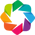

Launching server at http://localhost:55531


In [7]:
import pandas as pd
import numpy as np
import panel as pn
import holoviews as hv
from sklearn.metrics import r2_score, mean_absolute_error

# Enable extensions
hv.extension('bokeh')

# Load the data
def load_data():
    lstm_df = pd.read_csv('flow_forecasts_pca.csv')  # Updated to new PCA-based forecasts
    mso_df = pd.read_csv('MSO_forecast_9.csv')
    observed_df = pd.read_csv('Data/Clean/Orov_clean.csv')
    
    # Convert Date to datetime in observed data
    observed_df['Date'] = pd.to_datetime(observed_df['Date'])
    observed_df['Year'] = observed_df['Date'].dt.year
    observed_df['Month'] = observed_df['Date'].dt.month
    
    return lstm_df, mso_df, observed_df

def calculate_excel_r2(observed_values, forecast_values):
    """Calculate R-squared like Excel's CORREL^2"""
    if len(observed_values) != len(forecast_values):
        return None
        
    f_mean = np.mean(forecast_values)
    o_mean = np.mean(observed_values)
    
    numerator = sum((f - f_mean) * (o - o_mean) 
                    for f, o in zip(forecast_values, observed_values))
    
    f_variance = sum((f - f_mean) ** 2 for f in forecast_values)
    o_variance = sum((o - o_mean) ** 2 for o in observed_values)
    
    r = numerator / np.sqrt(f_variance * o_variance)
    return r ** 2

def create_comparison_plot(lstm_df, mso_df, observed_df, selected_year):
    # Get forecast data for selected year
    lstm_forecast = lstm_df[lstm_df['Year'] == selected_year].iloc[0]
    mso_forecast = mso_df[mso_df['Year'] == selected_year].iloc[0]
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
    month_nums = list(range(1, 10))
    
    # Create combined dataframe for all values
    plot_data = pd.DataFrame({
        'Month': month_nums,
        'Month_Name': months,
        'LSTM-PCA': [lstm_forecast[f'F_{m}'] for m in months],  # Updated label
        'MSO': [mso_forecast[m] for m in months]
    })
    
    # Add observed data
    observed_data = observed_df[
        (observed_df['Year'] == selected_year) & 
        (observed_df['Month'].isin(month_nums))
    ][['Month', 'F']].copy()
    
    plot_data = pd.merge(
        plot_data,
        observed_data,
        on='Month',
        how='left'
    ).rename(columns={'F': 'Observed'})
    
    # Create plot elements with tooltips
    hover_tool = HoverTool(
        tooltips=[
            ('Month', '@Month_Name'),
            ('Observed', '@Observed{0.0}'),
            ('LSTM-PCA', '@{LSTM-PCA}{0.0}'),  # Updated label
            ('MSO', '@MSO{0.0}')
        ]
    )
    
    observed = hv.Curve(plot_data, 'Month', 'Observed', label='Observed').opts(
        color='red', line_width=2
    )
    
    lstm = hv.Curve(plot_data, 'Month', 'LSTM-PCA', label='LSTM-PCA').opts(  # Updated label
        color='blue', line_width=2, line_dash='dashed'
    )
    
    mso = hv.Curve(plot_data, 'Month', 'MSO', label='MSO').opts(
        color='green', line_width=2, line_dash='dotted'
    )
    
    scatter = hv.Scatter(plot_data, 'Month', ['Observed', 'LSTM-PCA', 'MSO']).opts(  # Updated
        color='black', size=8, tools=[hover_tool]
    )
    
    # Combine all elements
    plot = (observed * lstm * mso * scatter).opts(
        width=700,
        height=400,
        title=f'Flow Comparison for Year {selected_year} (PCA-based LSTM)',  # Updated title
        xlabel='Month',
        ylabel='Flow',
        legend_position='right',
        show_grid=True
    )
    
    return plot

def calculate_metrics(lstm_df, mso_df, observed_df, selected_year):
    try:
        # Get forecasts
        lstm_forecast = lstm_df[lstm_df['Year'] == selected_year].iloc[0]
        mso_forecast = mso_df[mso_df['Year'] == selected_year].iloc[0]
        
        # Get values
        lstm_values = [lstm_forecast[f'F_{month}'] for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']]
        mso_values = [mso_forecast[month] for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']]
        
        observed_values = observed_df[
            (observed_df['Year'] == selected_year) & 
            (observed_df['Month'].isin(range(1, 10)))
        ]['F'].values
        
        if len(observed_values) == len(lstm_values):
            # LSTM metrics
            lstm_excel_r2 = calculate_excel_r2(observed_values, lstm_values)
            lstm_sklearn_r2 = r2_score(observed_values, lstm_values)
            lstm_mae = mean_absolute_error(observed_values, lstm_values)
            
            # MSO metrics
            mso_excel_r2 = calculate_excel_r2(observed_values, mso_values)
            mso_sklearn_r2 = r2_score(observed_values, mso_values)
            mso_mae = mean_absolute_error(observed_values, mso_values)
            
            return (lstm_excel_r2, lstm_sklearn_r2, lstm_mae,
                   mso_excel_r2, mso_sklearn_r2, mso_mae)
        else:
            return None
    except:
        return None

def create_dashboard():
    # Load data
    lstm_df, mso_df, observed_df = load_data()
    
    # Create containers
    plots_container = pn.Column()
    
    # Create year selector
    years = sorted(lstm_df['Year'].unique())
    year_select = pn.widgets.MultiChoice(
        name='Select Years',
        options=list(map(str, years)),
        value=[str(years[-1])],
        height=300
    )
    
    def update(event):
        plots_container.clear()
        
        for year_str in year_select.value:
            year = int(year_str)
            
            plot = create_comparison_plot(lstm_df, mso_df, observed_df, year)
            metrics = calculate_metrics(lstm_df, mso_df, observed_df, year)
            
            if metrics:
                lstm_excel_r2, lstm_sklearn_r2, lstm_mae, mso_excel_r2, mso_sklearn_r2, mso_mae = metrics
                metrics_text = (
                    f"**LSTM-PCA Metrics:**\n"  # Updated label
                    f"Excel R² (CORREL²): {lstm_excel_r2:.2f} | "
                    f"Sklearn R² (Determination): {lstm_sklearn_r2:.2f} | "
                    f"MAE: {int(lstm_mae)}\n\n"
                    f"**MSO Metrics:**\n"
                    f"Excel R² (CORREL²): {mso_excel_r2:.2f} | "
                    f"Sklearn R² (Determination): {mso_sklearn_r2:.2f} | "
                    f"MAE: {int(mso_mae)}"
                )
            else:
                metrics_text = "**Metrics:** Not available for this year"
            
            plots_container.extend([
                pn.pane.HoloViews(plot),
                pn.pane.Markdown(metrics_text),
                pn.layout.Divider()
            ])
    
    year_select.param.watch(update, 'value')
    update(None)
    
    dashboard = pn.Column(
        "## Flow Forecast Comparison (PCA-based LSTM)",  # Updated title
        pn.Row(
            pn.Column("### Select Years", year_select, width=300),
            plots_container
        )
    )
    
    return dashboard

# Create and display the dashboard
from bokeh.models import HoverTool
dashboard = create_dashboard()
pn.serve(dashboard)

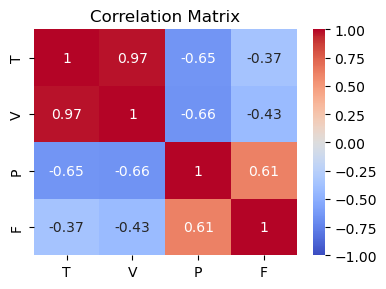

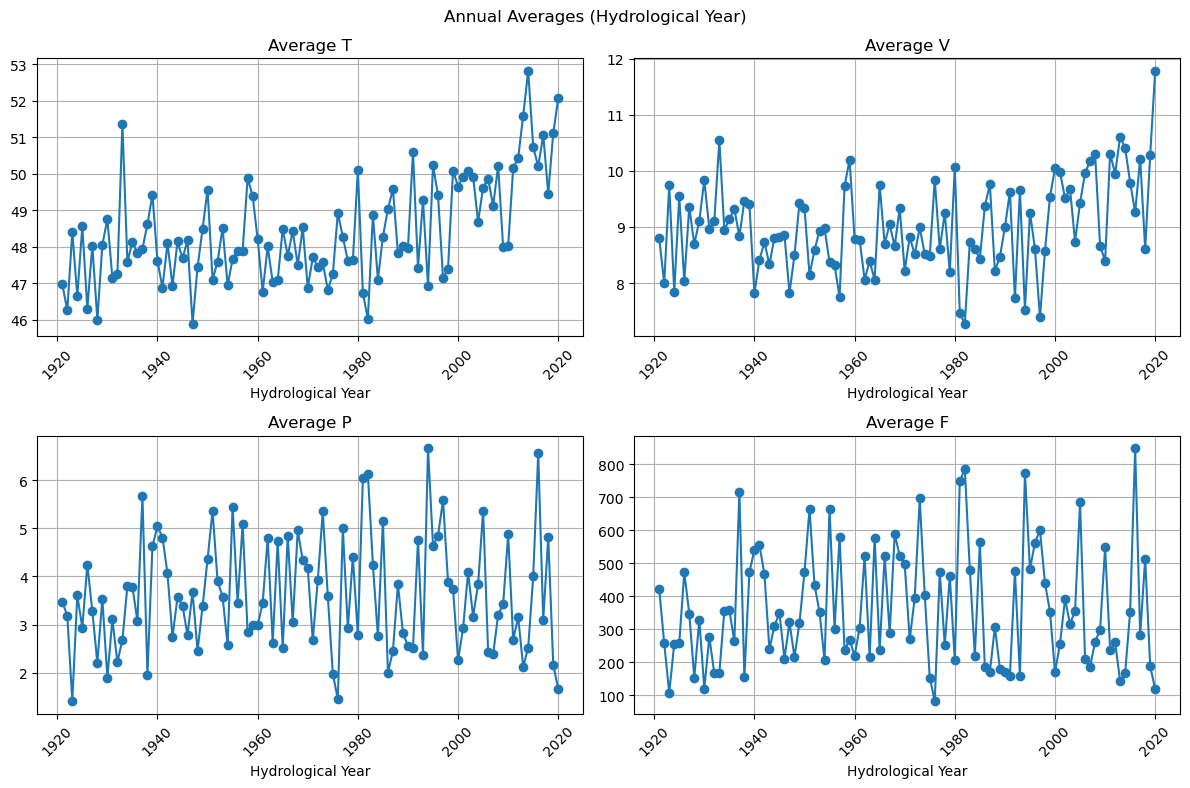


Basic Statistics by Hydrological Year:
                T           V           P           F
count  100.000000  100.000000  100.000000  100.000000
mean    48.421008    9.010029    3.605501  358.833221
std      1.423696    0.821348    1.180849  178.259219
min     45.897892    7.277005    1.411430   82.871667
25%     47.438146    8.477097    2.685766  216.117292
50%     48.076852    8.896991    3.445334  313.988875
75%     49.440136    9.566842    4.465580  477.236021
max     52.820771   11.783190    6.658852  847.611250


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# First, let's create the hydrological year
df['Date'] = pd.to_datetime(df['Date'])
df['Hydro_Year'] = df['Date'].apply(lambda x: x.year if x.month >= 10 else x.year - 1)

# Remove snow column and select only the variables we want
columns_to_analyze = ['T', 'V', 'P', 'F']
df_analysis = df[columns_to_analyze]

# Create correlation plot
plt.figure(figsize=(4, 3))
sns.heatmap(df_analysis.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Calculate annual averages by hydrological year
annual_avg = df.groupby('Hydro_Year')[columns_to_analyze].mean()

# Create subplots for annual averages
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Annual Averages (Hydrological Year)')

# Plot each variable
for idx, col in enumerate(columns_to_analyze):
    row = idx // 2
    col_idx = idx % 2
    axs[row, col_idx].plot(annual_avg.index, annual_avg[col], marker='o')
    axs[row, col_idx].set_title(f'Average {col}')
    axs[row, col_idx].set_xlabel('Hydrological Year')
    axs[row, col_idx].grid(True)
    # Rotate x-axis labels for better readability
    plt.setp(axs[row, col_idx].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Print some basic statistics for each variable by hydrological year
print("\nBasic Statistics by Hydrological Year:")
print(annual_avg.describe())

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Let's prepare the data for PCA
# First, we'll select just T and V columns
X = df[['T', 'V']]

# Standardize the features (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)  # We specify 2 components
X_pca = pca.fit_transform(X_scaled)

# Create a dataframe with the principal components
pc_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

# Let's see how much variance each component explains
print("Variance explained by each component:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.3f}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.3f}")

# Look at the component loadings
print("\nComponent loadings:")
print(pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=['T', 'V']
))

Variance explained by each component:
PC1: 0.987
PC2: 0.013

Component loadings:
        PC1       PC2
T  0.707107  0.707107
V  0.707107 -0.707107


In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib

# First, create X with all features
X = df[['F', 'P', 'T', 'V']].values

# Scale all features
scaler_all = StandardScaler()
X_scaled = scaler_all.fit_transform(X)

# Create PCA for T and V (which are columns 2 and 3 in X_scaled)
pca = PCA(n_components=1)
PCA1_TV = pca.fit_transform(X_scaled[:, [2, 3]])  # Using scaled T and V

# Create X_scaled_PCA by combining scaled F, P and PCA1_TV
X_scaled_PCA = np.column_stack([X_scaled[:, [0, 1]], PCA1_TV])  # Combining scaled F, P with PCA1_TV

# Save the preprocessors
preprocessing_objects = {
    'scaler_all': scaler_all,
    'pca': pca
}
joblib.dump(preprocessing_objects, 'preprocessing.joblib')

# Function to preprocess new data
def preprocess_new_data(new_df):
    # Load preprocessing objects
    prep_obj = joblib.load('preprocessing.joblib')
    scaler_all = prep_obj['scaler_all']
    pca = prep_obj['pca']
    
    # Scale all features
    X_new = new_df[['F', 'P', 'T', 'V']].values
    X_new_scaled = scaler_all.transform(X_new)
    
    # Create PCA for T and V
    PCA1_TV_new = pca.transform(X_new_scaled[:, [2, 3]])
    
    # Combine scaled F, P with PCA1_TV
    X_new_scaled_PCA = np.column_stack([X_new_scaled[:, [0, 1]], PCA1_TV_new])
    
    return X_new_scaled_PCA

# Example of the final dataframe structure
df_final = pd.DataFrame(X_scaled_PCA, columns=['F_scaled', 'P_scaled', 'PCA1_TV'])
print("First few rows of the preprocessed data:")
print(df_final.head())

First few rows of the preprocessed data:
   F_scaled  P_scaled   PCA1_TV
0 -0.729572 -0.563357  0.215775
1 -0.680169 -0.217463 -0.646410
2 -0.433153  1.526359 -1.379921
3 -0.438409 -0.147391 -1.718402
4  0.165991  2.493828 -1.802310


c:\Users\peymanhn\AppData\Local\anaconda3\envs\ML_DWR_2025\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,113 (129.35 KB)

 Trainable params: 33,113 (129.35 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5000
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.1025
Epoch 2/5000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8873
Epoch 3/5000
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.8057
Epoch 4/5000
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6975
Epoch 5/5000
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6526
Epoch 6/5000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6483
Epoch 7/5000
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6331
Epoch 8/5000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6551
Epoch 9/5000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6470
Epoch 10/5000
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6451
Epoch 11/5000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6283
Epoch 12/5000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6200
Epoch 13/5000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6000
Epoch 14/5000
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6471
Epoch 15/5000
37/37 ━━━━━━━━━━━━━━━━━━

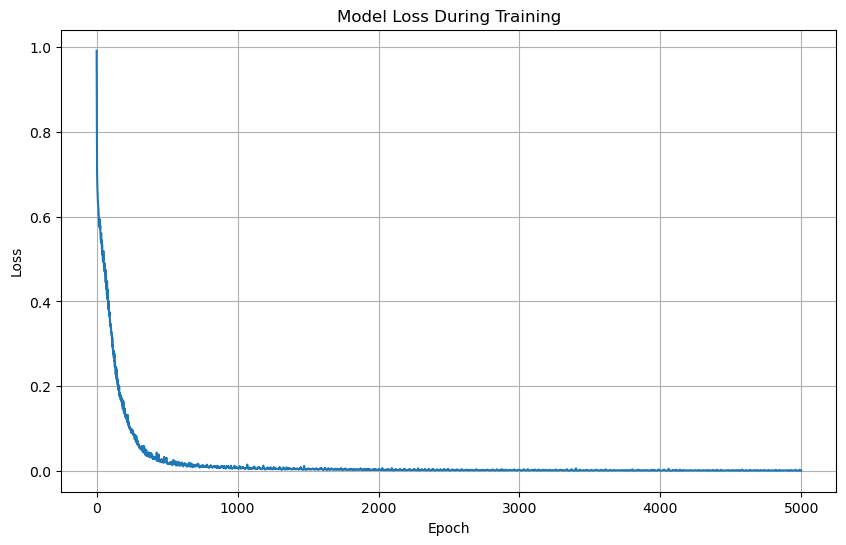

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# Prepare sequences for LSTM
def create_sequences(data, input_window, output_window):
    X, y = [], []
    total_window = input_window + output_window
    
    for i in range(len(data) - total_window + 1):
        X.append(data[i:(i + input_window)])
        y.append(data[(i + input_window):(i + input_window + output_window), 0])  # Only F values
    
    return np.array(X), np.array(y)

# Parameters
input_window = 12
output_window = 9
n_features = df_final.shape[1]  # Number of features (F_scaled, P_scaled, PCA1_TV)

# Create sequences
data = df_final.values
X, y = create_sequences(data, input_window, output_window)

# Build LSTM model
model = Sequential([
    # First LSTM layer
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(input_window, n_features)),
    
    # Second LSTM layer
    LSTM(32, activation='relu', return_sequences=True),
    
    # Third LSTM layer
    LSTM(16, activation='relu'),
    
    # Output layer
    Dense(output_window)  # Predicts 9 months of flow
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Model summary
print(model.summary())

# Train model
history = model.fit(X, y, 
                   epochs=5000,
                   batch_size=32,
                   verbose=1)

# Plot training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Save the model
model.save('lstm_model.h5')

In [13]:
# Save the model in .keras format
model.save('lstm_model.keras')  # Changed from .h5 to .keras

c:\Users\peymanhn\AppData\Local\anaconda3\envs\ML_DWR_2025\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



First few rows of forecasts:
   Year       F_Jan        F_Feb       F_Mar       F_Apr       F_May  \
0  1922  307.279969   205.091949  356.260414  646.197564  477.466263   
1  1923  102.373684   289.977938  120.139230  165.745957   99.095305   
2  1924  158.854207   768.891812  379.883287  537.087689  417.717660   
3  1925  153.126865   618.560158  408.879565  871.292846  319.761908   
4  1926  371.137718  1263.429045  778.192605  918.574123  740.619944   

        F_Jun       F_Jul       F_Aug      F_Sep  
0  232.742045  122.834611   76.782567  83.930216  
1   63.762274   58.543033   63.706884  56.403205  
2  191.308177  113.930801   82.688576  73.816928  
3  136.634805   92.860451   74.080540  83.403606  
4  376.491061  162.725314  102.786430  92.494272  

Basic statistics of forecasts:
              Year        F_Jan        F_Feb        F_Mar        F_Apr  \
count   100.000000   100.000000   100.000000   100.000000   100.000000   
mean   1971.500000   482.242852   553.498131   662.

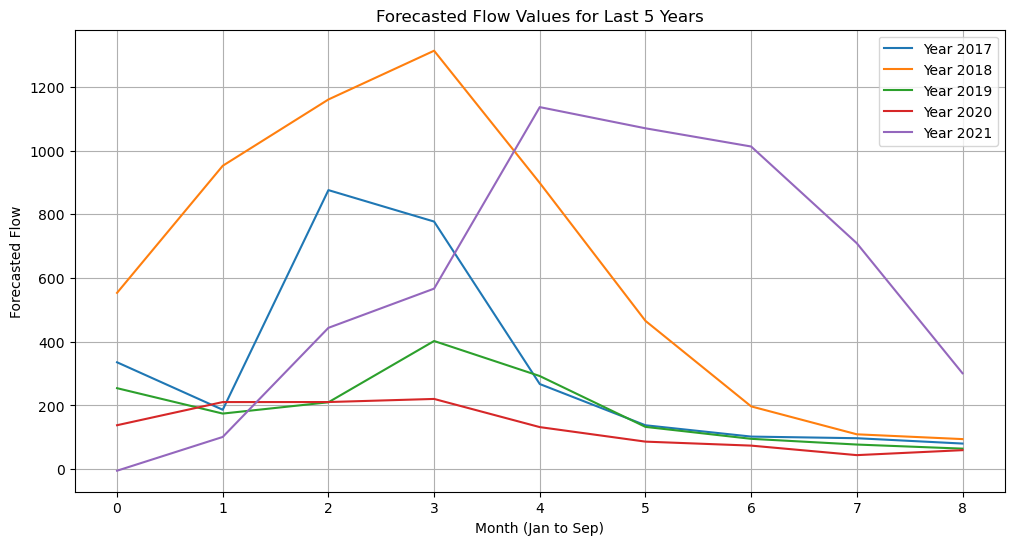

In [14]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import joblib

# Load the saved model and preprocessing objects
model = load_model('lstm_model.keras')
prep_obj = joblib.load('preprocessing.joblib')
scaler_all = prep_obj['scaler_all']
pca = prep_obj['pca']

# Parameters
input_window = 12
output_window = 9

# Function to preprocess data
def preprocess_data(df):
    X = df[['F', 'P', 'T', 'V']].values
    X_scaled = scaler_all.transform(X)
    PCA1_TV = pca.transform(X_scaled[:, [2, 3]])
    X_scaled_PCA = np.column_stack([X_scaled[:, [0, 1]], PCA1_TV])
    return X_scaled_PCA

# Create predictions for each December
forecasts = []
years = []

# Convert date to datetime if not already
df['Date'] = pd.to_datetime(df['Date'])

# Loop through each year
for year in range(1922, 2022):  # 1922 to 2021
    # Get data up to December of current year
    mask = (df['Date'] <= f'{year}-12-01')
    data_until_dec = df[mask].copy()
    
    if len(data_until_dec) >= input_window:  # Ensure we have enough data for input window
        # Preprocess the data
        processed_data = preprocess_data(data_until_dec)
        
        # Get the last input_window timesteps
        input_sequence = processed_data[-input_window:]
        input_sequence = input_sequence.reshape((1, input_window, 3))  # Reshape for LSTM
        
        # Make prediction
        prediction_scaled = model.predict(input_sequence, verbose=0)
        
        # Reshape prediction for inverse transform
        pred_reshaped = np.column_stack([
            prediction_scaled.reshape(output_window, 1),
            np.zeros((output_window, 3))  # Placeholder for P, T, V
        ])
        
        # Inverse transform to get original scale
        prediction_original = scaler_all.inverse_transform(pred_reshaped)[:, 0]
        
        # Store results
        years.append(year)
        forecasts.append(prediction_original)

# Create the final dataframe
forecast_df = pd.DataFrame(forecasts, 
                          columns=[f'F_{month}' for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']])
forecast_df.insert(0, 'Year', years)

# Display the first few rows
print("\nFirst few rows of forecasts:")
print(forecast_df.head())

# Save to CSV
forecast_df.to_csv('flow_forecasts.csv', index=False)

# Optional: Calculate and show basic statistics of the forecasts
print("\nBasic statistics of forecasts:")
print(forecast_df.describe())

# Optional: Plot the forecasts for a few years
import matplotlib.pyplot as plt

# Plot last 5 years as example
last_5_years = forecast_df.tail()
plt.figure(figsize=(12, 6))
for _, row in last_5_years.iterrows():
    plt.plot(range(9), row[1:], label=f'Year {int(row["Year"])}')
plt.xlabel('Month (Jan to Sep)')
plt.ylabel('Forecasted Flow')
plt.title('Forecasted Flow Values for Last 5 Years')
plt.legend()
plt.grid(True)
plt.show()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
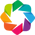

Launching server at http://localhost:61616


In [5]:
import pandas as pd
import numpy as np
import panel as pn
import holoviews as hv
from sklearn.metrics import r2_score, mean_absolute_error
import datetime

# Enable extensions
hv.extension('bokeh')

# Load the data
def load_data():
    forecast_df = pd.read_csv('flow_forecasts.csv')
    observed_df = pd.read_csv('Data/Clean/Orov_clean.csv')  # Updated path
    
    # Convert Date to datetime in observed data
    observed_df['Date'] = pd.to_datetime(observed_df['Date'])
    observed_df['Year'] = observed_df['Date'].dt.year
    observed_df['Month'] = observed_df['Date'].dt.month
    
    return forecast_df, observed_df

# Create comparison plot
def create_comparison_plot(forecast_df, observed_df, selected_year):
    # Get forecast data for selected year
    year_forecast = forecast_df[forecast_df['Year'] == selected_year].iloc[0]
    
    # Create forecast dataframe in long format
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
    month_nums = list(range(1, 10))
    
    forecast_data = pd.DataFrame({
        'Month': month_nums,
        'Flow': [year_forecast[f'F_{m}'] for m in months],
        'Type': 'Forecast'
    })
    
    # Get observed data for selected year and months
    observed_data = observed_df[
        (observed_df['Year'] == selected_year) & 
        (observed_df['Month'].isin(month_nums))
    ][['Month', 'F']].copy()
    
    observed_data['Type'] = 'Observed'
    observed_data = observed_data.rename(columns={'F': 'Flow'})
    
    # Create separate curves for forecast and observed
    forecast_curve = hv.Curve(
        forecast_data, 
        'Month', 'Flow', 
        label='Forecast'
    ).opts(color='blue', line_dash='dashed')
    
    observed_curve = hv.Curve(
        observed_data, 
        'Month', 'Flow',
        label='Observed'
    ).opts(color='red')
    
    # Create scatter points
    forecast_points = hv.Scatter(
        forecast_data, 
        'Month', 'Flow',
        label='Forecast'
    ).opts(color='blue', size=8)
    
    observed_points = hv.Scatter(
        observed_data, 
        'Month', 'Flow',
        label='Observed'
    ).opts(color='red', size=8)
    
    # Combine all elements
    plot = (forecast_curve * observed_curve * forecast_points * observed_points).opts(
        width=700,
        height=400,
        title=f'Flow Comparison for Year {selected_year}',
        xlabel='Month',
        ylabel='Flow',
        legend_position='right',
        tools=['hover']
    )
    
    return plot

# Calculate metrics
def calculate_metrics(forecast_df, observed_df, selected_year):
    try:
        year_forecast = forecast_df[forecast_df['Year'] == selected_year].iloc[0]
        forecast_values = [year_forecast[f'F_{month}'] for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']]
        
        observed_values = observed_df[
            (observed_df['Year'] == selected_year) & 
            (observed_df['Month'].isin(range(1, 10)))
        ]['F'].values
        
        if len(observed_values) == len(forecast_values):
            r2 = r2_score(observed_values, forecast_values)
            mae = mean_absolute_error(observed_values, forecast_values)
            return r2, mae
        else:
            return None, None
    except:
        return None, None

# Create the dashboard
def create_dashboard():
    # Load data
    forecast_df, observed_df = load_data()
    
    # Create year selector
    year_select = pn.widgets.Select(
        name='Select Year',
        options=sorted(forecast_df['Year'].unique()),
        value=sorted(forecast_df['Year'].unique())[0]
    )
    
    # Create plot pane
    plot_pane = pn.pane.HoloViews()
    
    # Create metrics display
    r2_text = pn.pane.Markdown("R-squared: --")
    mae_text = pn.pane.Markdown("MAE: --")

    def update(event):
        # Update plot
        new_plot = create_comparison_plot(forecast_df, observed_df, year_select.value)
        plot_pane.object = new_plot
        
        # Update metrics
        r2, mae = calculate_metrics(forecast_df, observed_df, year_select.value)
        if r2 is not None and mae is not None:
            r2_text.object = f"**R-squared:** {r2:.4f}"
            mae_text.object = f"**MAE:** {mae:.4f}"
        else:
            r2_text.object = "**R-squared:** Not available"
            mae_text.object = "**MAE:** Not available"
    
    # Set up the callback
    year_select.param.watch(update, 'value')
    
    # Initial update
    update(None)
    
    # Create layout
    dashboard = pn.Column(
        pn.Row(year_select),
        pn.Row(plot_pane),
        pn.Row(r2_text, mae_text)
    )
    
    return dashboard

# Create and display the dashboard
dashboard = create_dashboard()
pn.serve(dashboard)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
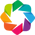

AttributeError: module 'holoviews' has no attribute 'HoloViews'

In [ ]:
import pandas as pd
import numpy as np
import panel as pn
import holoviews as hv
from sklearn.metrics import r2_score, mean_absolute_error

# Enable extensions
hv.extension('bokeh')

# Load the data
def load_data():
    forecast_df = pd.read_csv('flow_forecasts.csv')
    observed_df = pd.read_csv('Data/Clean/Orov_clean.csv')
    
    # Convert Date to datetime in observed data
    observed_df['Date'] = pd.to_datetime(observed_df['Date'])
    observed_df['Year'] = observed_df['Date'].dt.year
    observed_df['Month'] = observed_df['Date'].dt.month
    
    return forecast_df, observed_df

def calculate_excel_r2(observed_values, forecast_values):
    """Calculate R-squared like Excel's CORREL^2"""
    if len(observed_values) != len(forecast_values):
        return None
        
    f_mean = np.mean(forecast_values)
    o_mean = np.mean(observed_values)
    
    numerator = sum((f - f_mean) * (o - o_mean) 
                    for f, o in zip(forecast_values, observed_values))
    
    f_variance = sum((f - f_mean) ** 2 for f in forecast_values)
    o_variance = sum((o - o_mean) ** 2 for o in observed_values)
    
    r = numerator / np.sqrt(f_variance * o_variance)
    return r ** 2

# Create comparison plot
def create_comparison_plot(forecast_df, observed_df, selected_year):
    # Get forecast data for selected year
    year_forecast = forecast_df[forecast_df['Year'] == selected_year].iloc[0]
    
    # Create forecast dataframe in long format
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
    month_nums = list(range(1, 10))
    
    forecast_data = pd.DataFrame({
        'Month': month_nums,
        'Flow': [year_forecast[f'F_{m}'] for m in months],
        'Type': 'Forecast'
    })
    
    # Get observed data for selected year and months
    observed_data = observed_df[
        (observed_df['Year'] == selected_year) & 
        (observed_df['Month'].isin(month_nums))
    ][['Month', 'F']].copy()
    
    observed_data['Type'] = 'Observed'
    observed_data = observed_data.rename(columns={'F': 'Flow'})
    
    # Create plot elements
    plot = hv.Curve(forecast_data, 'Month', 'Flow', label='Forecast').opts(color='blue', line_dash='dashed') * \
           hv.Scatter(forecast_data, 'Month', 'Flow').opts(color='blue', size=8) * \
           hv.Curve(observed_data, 'Month', 'Flow', label='Observed').opts(color='red') * \
           hv.Scatter(observed_data, 'Month', 'Flow').opts(color='red', size=8)
    
    plot = plot.opts(
        width=700,
        height=400,
        title=f'Flow Comparison for Year {selected_year}',
        xlabel='Month',
        ylabel='Flow',
        legend_position='right',
        tools=['hover']
    )
    
    return plot

# Calculate metrics
def calculate_metrics(forecast_df, observed_df, selected_year):
    try:
        year_forecast = forecast_df[forecast_df['Year'] == selected_year].iloc[0]
        forecast_values = [year_forecast[f'F_{month}'] for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']]
        
        observed_values = observed_df[
            (observed_df['Year'] == selected_year) & 
            (observed_df['Month'].isin(range(1, 10)))
        ]['F'].values
        
        if len(observed_values) == len(forecast_values):
            excel_r2 = calculate_excel_r2(observed_values, forecast_values)
            sklearn_r2 = r2_score(observed_values, forecast_values)
            mae = mean_absolute_error(observed_values, forecast_values)
            return excel_r2, sklearn_r2, mae
        else:
            return None, None, None
    except:
        return None, None, None

def create_dashboard():
    # Load data
    forecast_df, observed_df = load_data()
    
    # Create containers
    plots_container = pn.Column()
    main_container = pn.Column(name='Main')
    
    # Create year selector
    years = sorted(forecast_df['Year'].unique())
    year_select = pn.widgets.MultiChoice(
        name='Select Years',
        options=list(map(str, years)),
        value=[str(years[-1])],
        height=300
    )
    
    def update(event):
        # Clear the main container
        plots_container.clear()
        
        # Create plots for each selected year
        for year_str in year_select.value:
            year = int(year_str)
            
            # Create plot
            plot = create_comparison_plot(forecast_df, observed_df, year)
            
            # Calculate metrics
            excel_r2, sklearn_r2, mae = calculate_metrics(forecast_df, observed_df, year)
            
            # Create metrics text
            if excel_r2 is not None:
                metrics_text = (
                    f"**Excel R² (CORREL²):** {excel_r2:.2f} | "
                    f"**Sklearn R² (Determination):** {sklearn_r2:.2f} | "
                    f"**MAE:** {int(mae)}"
                )
            else:
                metrics_text = "**Metrics:** Not available for this year"
            
            # Add to container
            plots_container.extend([
                pn.pane.HoloViews(plot),
                pn.pane.Markdown(metrics_text),
                pn.layout.Divider()
            ])
    
    # Set up the callback
    year_select.param.watch(update, 'value')
    
    # Initial update
    update(None)
    
    # Create layout
    dashboard = pn.Column(
        "## Flow Forecast Comparison",
        pn.Row(
            pn.Column("### Select Years", year_select, width=300),
            plots_container
        )
    )
    
    return dashboard

# Create and display the dashboard
dashboard = create_dashboard()
pn.serve(dashboard)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
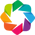

Launching server at http://localhost:63211


In [6]:
import pandas as pd
import numpy as np
import panel as pn
import holoviews as hv
from sklearn.metrics import r2_score, mean_absolute_error

# Enable extensions
hv.extension('bokeh')

# Load the data
def load_data():
    lstm_df = pd.read_csv('flow_forecasts.csv')
    mso_df = pd.read_csv('MSO_forecast_9.csv')
    observed_df = pd.read_csv('Data/Clean/Orov_clean.csv')
    
    # Convert Date to datetime in observed data
    observed_df['Date'] = pd.to_datetime(observed_df['Date'])
    observed_df['Year'] = observed_df['Date'].dt.year
    observed_df['Month'] = observed_df['Date'].dt.month
    
    return lstm_df, mso_df, observed_df

def calculate_excel_r2(observed_values, forecast_values):
    """Calculate R-squared like Excel's CORREL^2"""
    if len(observed_values) != len(forecast_values):
        return None
        
    f_mean = np.mean(forecast_values)
    o_mean = np.mean(observed_values)
    
    numerator = sum((f - f_mean) * (o - o_mean) 
                    for f, o in zip(forecast_values, observed_values))
    
    f_variance = sum((f - f_mean) ** 2 for f in forecast_values)
    o_variance = sum((o - o_mean) ** 2 for o in observed_values)
    
    r = numerator / np.sqrt(f_variance * o_variance)
    return r ** 2

# Create comparison plot
def create_comparison_plot(lstm_df, mso_df, observed_df, selected_year):
    # Get forecast data for selected year
    lstm_forecast = lstm_df[lstm_df['Year'] == selected_year].iloc[0]
    mso_forecast = mso_df[mso_df['Year'] == selected_year].iloc[0]
    
    # Create forecast dataframes in long format
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
    month_nums = list(range(1, 10))
    
    # Create combined dataframe for all values
    plot_data = pd.DataFrame({
        'Month': month_nums,
        'Month_Name': months,
        'LSTM': [lstm_forecast[f'F_{m}'] for m in months],
        'MSO': [mso_forecast[m] for m in months]
    })
    
    # Add observed data
    observed_data = observed_df[
        (observed_df['Year'] == selected_year) & 
        (observed_df['Month'].isin(month_nums))
    ][['Month', 'F']].copy()
    
    plot_data = pd.merge(
        plot_data,
        observed_data,
        on='Month',
        how='left'
    ).rename(columns={'F': 'Observed'})
    
    # Create plot elements with tooltips
    hover_tool = HoverTool(
        tooltips=[
            ('Month', '@Month_Name'),
            ('Observed', '@Observed{0.0}'),
            ('LSTM', '@LSTM{0.0}'),
            ('MSO', '@MSO{0.0}')
        ]
    )
    
    observed = hv.Curve(plot_data, 'Month', 'Observed', label='Observed').opts(
        color='red', line_width=2
    )
    
    lstm = hv.Curve(plot_data, 'Month', 'LSTM', label='LSTM').opts(
        color='blue', line_width=2, line_dash='dashed'
    )
    
    mso = hv.Curve(plot_data, 'Month', 'MSO', label='MSO').opts(
        color='green', line_width=2, line_dash='dotted'
    )
    
    scatter = hv.Scatter(plot_data, 'Month', ['Observed', 'LSTM', 'MSO']).opts(
        color='black', size=8, tools=[hover_tool]
    )
    
    # Combine all elements
    plot = (observed * lstm * mso * scatter).opts(
        width=700,
        height=400,
        title=f'Flow Comparison for Year {selected_year}',
        xlabel='Month',
        ylabel='Flow',
        legend_position='right',
        show_grid=True
    )
    
    return plot

# Calculate metrics for both forecasts
def calculate_metrics(lstm_df, mso_df, observed_df, selected_year):
    try:
        # Get forecasts
        lstm_forecast = lstm_df[lstm_df['Year'] == selected_year].iloc[0]
        mso_forecast = mso_df[mso_df['Year'] == selected_year].iloc[0]
        
        # Get values
        lstm_values = [lstm_forecast[f'F_{month}'] for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']]
        mso_values = [mso_forecast[month] for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']]
        
        observed_values = observed_df[
            (observed_df['Year'] == selected_year) & 
            (observed_df['Month'].isin(range(1, 10)))
        ]['F'].values
        
        if len(observed_values) == len(lstm_values):
            # LSTM metrics
            lstm_excel_r2 = calculate_excel_r2(observed_values, lstm_values)
            lstm_sklearn_r2 = r2_score(observed_values, lstm_values)
            lstm_mae = mean_absolute_error(observed_values, lstm_values)
            
            # MSO metrics
            mso_excel_r2 = calculate_excel_r2(observed_values, mso_values)
            mso_sklearn_r2 = r2_score(observed_values, mso_values)
            mso_mae = mean_absolute_error(observed_values, mso_values)
            
            return (lstm_excel_r2, lstm_sklearn_r2, lstm_mae,
                   mso_excel_r2, mso_sklearn_r2, mso_mae)
        else:
            return None
    except:
        return None

def create_dashboard():
    # Load data
    lstm_df, mso_df, observed_df = load_data()
    
    # Create containers
    plots_container = pn.Column()
    
    # Create year selector
    years = sorted(lstm_df['Year'].unique())
    year_select = pn.widgets.MultiChoice(
        name='Select Years',
        options=list(map(str, years)),
        value=[str(years[-1])],
        height=300
    )
    
    def update(event):
        # Clear the container
        plots_container.clear()
        
        # Create plots for each selected year
        for year_str in year_select.value:
            year = int(year_str)
            
            # Create plot
            plot = create_comparison_plot(lstm_df, mso_df, observed_df, year)
            
            # Calculate metrics
            metrics = calculate_metrics(lstm_df, mso_df, observed_df, year)
            
            if metrics:
                lstm_excel_r2, lstm_sklearn_r2, lstm_mae, mso_excel_r2, mso_sklearn_r2, mso_mae = metrics
                metrics_text = (
                    f"**LSTM Metrics:**\n"
                    f"Excel R² (CORREL²): {lstm_excel_r2:.2f} | "
                    f"Sklearn R² (Determination): {lstm_sklearn_r2:.2f} | "
                    f"MAE: {int(lstm_mae)}\n\n"
                    f"**MSO Metrics:**\n"
                    f"Excel R² (CORREL²): {mso_excel_r2:.2f} | "
                    f"Sklearn R² (Determination): {mso_sklearn_r2:.2f} | "
                    f"MAE: {int(mso_mae)}"
                )
            else:
                metrics_text = "**Metrics:** Not available for this year"
            
            # Add to container
            plots_container.extend([
                pn.pane.HoloViews(plot),
                pn.pane.Markdown(metrics_text),
                pn.layout.Divider()
            ])
    
    # Set up the callback
    year_select.param.watch(update, 'value')
    
    # Initial update
    update(None)
    
    # Create layout
    dashboard = pn.Column(
        "## Flow Forecast Comparison",
        pn.Row(
            pn.Column("### Select Years", year_select, width=300),
            plots_container
        )
    )
    
    return dashboard

# Create and display the dashboard
from bokeh.models import HoverTool
dashboard = create_dashboard()
pn.serve(dashboard)